![texto alternativo](https://pbs.twimg.com/profile_images/621342633655271424/26fdqUsf_400x400.png)
# MBDM Módulo 5 (caso práctico grupal)
Modelos no supervisados 
para identificación de perfiles de usuarios
del servicio BiciMAD

## Cargar el dataset de BiciMAD de todos los trayectos que empiezan o/y terminan en Retiro

In [0]:
import pandas as pd
bicimad = pd.read_csv('Bmadretiropark.csv', sep = ';', encoding='latin-1')
bicimad.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['datesample', 'oid', 'user_day_code', 'idplug_base', 'user_type',
       'idunplug_base', 'travel_time', 'idunplug_station', 'ageRange',
       'idplug_station', 'zip_code', 'longitude', 'latitude', 'var', 'speed',
       'secondsfromstart', 'daysample'],
      dtype='object')



---


## Descripción de las variables del dataset

***Hay que tener en cuenta el hecho de que cada registro del dataset conlleva la información de la captura de una posición durante el trayecto. Cada trayento consiste de varias de esas capturas de posición y velocidad para poder tener una idea más amplia de la ruta que realizó el usuario.***

Por esta razón, cada registro tiene datos tanto del trayecto en general (e.g. estación de partida y destino), así como del momento captado (e.g. coordenadas de la posición y velocidad):

> ### Datos de cada trayecto:
* **datesample:** Fecha y hora del trayecto/movimiento.
* **daysample:** Fecha del trayecto/movimiento.
* **oid:** Identificador del trayecto/movimiento.
* **user_day_code:** Código del usuario para una misma fecha.
* **idunplug_station:** Número de la estación de la que se desengancha la bicicleta.
* **idunplug_base:** Número de la base de la que se desengancha la bicicleta.
* **idplug_station:** Número de la estación en la que se engancha la bicicleta.
* **idplug_base:** Número de la base en la que se engancha la bicicleta.
* **travel_time:**  Tiempo total en segundos, entre el desenganche y el enganche de la
bicicleta.
* **user_type:**  Número que indica el tipo de usuario que ha realizado el movimiento.
* **ageRange:**  Número que indica el rango de edad del usuario que ha realizado el
movimiento.
* **zip_code:**  Texto que indica el código postal del usuario que ha realizado el movimiento.

> ### Datos de cada captura:
* **secondsfromstart:** Segundos transcurridos desde el desenganche de la
bicicleta hasta el momento de generarse el dato.
* **var:**  Texto con la dirección de la posición.
* **speed:**  Velocidad de la bicicleta en el momento de generarse el dato.
* **longitude:**  Coordenadas de longitud de la posición.
* **latitud:**  Coordenadas de latitud de la posición.

In [0]:
# Muestra del dataset utilizando un trayecto en concreto, donde se ve que las primeras variables tienen los mismos valores y las del final son las capturas momentaneas de posición y velocidad.
bicimad_eg=bicimad[bicimad['oid'] == '5b6779012f384302541d6821']
bicimad_eg.head(30)

,datesample,oid,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,zip_code,longitude,latitude,var,speed,secondsfromstart,daysample
0,2018-08-01 01:00:00.000000,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.703808,40.416972,"28013,ES,Madrid,Madrid,CALLE PRECIADOS,Madrid",7.97,451.0,2018-08-01
1,2018-08-01 01:00:00.000000,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.699525,40.417932,"28014,ES,Madrid,Madrid,CALLE ALCALA 21,Madrid",3.69,391.0,2018-08-01
2,2018-08-01 01:00:00.000000,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.696287,40.418957,"28014,ES,Madrid,Madrid,CALLE ALCALA 45,Madrid",6.91,331.0,2018-08-01
3,2018-08-01 01:00:00.000000,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.690708,40.419882,"28014,ES,Madrid,Madrid,CALLE ALCALA 63,Madrid",8.13,272.0,2018-08-01
4,2018-08-01 01:00:00.000000,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.686219,40.420554,"28009,ES,Madrid,Madrid,CALLE ALCALA 83,Madrid",8.77,212.0,2018-08-01
5,2018-08-01 01:00:00.000000,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.682659,40.421482,"28009,ES,Madrid,Madrid,CALLE ALCALA,Madrid",0.00,152.0,2018-08-01
6,2018-08-01 01:00:00.000000,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.680973,40.421404,"28009,ES,Madrid,Madrid,CALLE O'DONNELL,Madrid",5.25,92.0,2018-08-01


In [0]:
# Librerias y formato de los graficos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')



---


## Enriquecer el dataset con variables


In [0]:
bicimad['datesample'] = pd.to_datetime(bicimad['datesample'], errors = 'coerce')

# Crear variable "day" con el día de Agosto
bicimad['day'] = bicimad['datesample'].dt.strftime('%d')

# Crear variable "hour" con la hora del día
bicimad['hour'] = bicimad['datesample'].dt.strftime('%H')

# Crear variable "travel_time_min" con la duración de trayecto en minutos
bicimad['travel_time_min'] = bicimad['travel_time']/60

#crear variable "day_morning" con la definición de si corresponde a los rangos de hora 'mañana, tarde y noche'
def true_false(x):
  if (x>0) and (x<=6):
     return 1
  
  elif (x>6) and (x<=12):
     return 2
    
  elif (x>12) and (x<=18):
      return 3
  else:
      return 4 
bicimad['day_morning'] = bicimad['datesample'].dt.strftime('%H').astype(int).apply(lambda x: true_false(x))

#crear variable "hora_rango" con la definición de si corresponde a los rangos de hora 'madrugada, mañana, tarde y noche'
def hora_rango(x):
  if x==1:
    return 'madrugada'
  elif x==2:
    return 'mañana'
  elif x==3:
    return 'tarde'
  else:
    return 'noche'

bicimad['rango_hora'] = bicimad['day_morning'].apply(lambda x: hora_rango(x))
# Crear variable "weekday" con el número del día de la semana (valores 0-6 para L-D)
bicimad['weekday'] = bicimad['datesample'].dt.dayofweek

# Crear variable "business_day" con la definición del día en laborable (1) y fin de semana (0)
def tipo_dia(x):
  if (x<=4):
    return 1
  else:
    return 0
bicimad['business_day'] = bicimad['weekday'].apply(lambda x: tipo_dia(x))

bicimad['unidad'] = 1 
bicimad.head()

,datesample,oid,user_day_code,idplug_base,user_type,idunplug_base,travel_time,idunplug_station,ageRange,idplug_station,zip_code,longitude,latitude,var,speed,secondsfromstart,daysample,day,hour,travel_time_min,day_morning,rango_hora,weekday,business_day,unidad
0,2018-08-01 01:00:00,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.703808,40.416972,"28013,ES,Madrid,Madrid,CALLE PRECIADOS,Madrid",7.97,451.0,2018-08-01,01,01,8.3,1,madrugada,2,1,1
1,2018-08-01 01:00:00,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.699525,40.417932,"28014,ES,Madrid,Madrid,CALLE ALCALA 21,Madrid",3.69,391.0,2018-08-01,01,01,8.3,1,madrugada,2,1,1
2,2018-08-01 01:00:00,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.696287,40.418957,"28014,ES,Madrid,Madrid,CALLE ALCALA 45,Madrid",6.91,331.0,2018-08-01,01,01,8.3,1,madrugada,2,1,1
3,2018-08-01 01:00:00,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.690708,40.419882,"28014,ES,Madrid,Madrid,CALLE ALCALA 63,Madrid",8.13,272.0,2018-08-01,01,01,8.3,1,madrugada,2,1,1
4,2018-08-01 01:00:00,5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,9,1,22,498,90,0,35,NaN,-3.686219,40.420554,"28009,ES,Madrid,Madrid,CALLE ALCALA 83,Madrid",8.77,212.0,2018-08-01,01,01,8.3,1,madrugada,2,1,1


In [0]:
print("DURANTE EL MES DE AGOSTO 2018 SE REALIZARON", bicimad['unidad'].count() , "DE REGISTROS-CAPTURAS DE BICIMAD")

DURANTE EL MES DE AGOSTO 2018 SE REALIZARON 177939 DE REGISTROS-CAPTURAS DE BICIMAD


## Crear nuevo dataset con los datos por id de trayecto

In [0]:
bicimad_id = bicimad.loc[:, ['user_day_code','daysample','datesample','day','oid', 'user_type', 'idplug_station', 'idunplug_station', 'ageRange','speed','travel_time_min','day_morning','weekday','business_day','unidad','rango_hora','hour']]
bicimad_id = bicimad_id.groupby('oid').agg({'user_day_code':'first','day':'first','datesample':'first','daysample':'first','idplug_station':'first', 'idunplug_station':'first','unidad':'first','speed':'mean','travel_time_min':'first','user_type':'mean','ageRange':'first','weekday':'first','business_day':'first','day_morning':'first', 'rango_hora':'first','hour':'first'})
bicimad_id.head()

,user_day_code,day,datesample,daysample,idplug_station,idunplug_station,unidad,speed,travel_time_min,user_type,ageRange,weekday,business_day,day_morning,rango_hora,hour
oid,,,,,,,,,,,,,,,,
5b6779012f384302541d6821,0279839c9c173d430f87eaff66719268979afc65dde413...,01,2018-08-01 01:00:00,2018-08-01,35,90,1,5.817143,8.300000,1,0,2,1,1,madrugada,01
5b6779012f384302541d682b,9b46b414029386426aa0cafa579ba5c3b4c3d72099df44...,01,2018-08-01 01:00:00,2018-08-01,45,90,1,5.557778,9.000000,1,4,2,1,1,madrugada,01
5b6779012f384302541d6838,b32223eeec968dbd5a3cf4cede30756c79abe5a11e5112...,01,2018-08-01 01:00:00,2018-08-01,166,90,1,4.290000,5.683333,1,5,2,1,1,madrugada,01
5b6779012f384302541d6848,9fef17ea340b41885422f289d1c456b1291beb61c68dbb...,01,2018-08-01 01:00:00,2018-08-01,76,73,1,3.842727,11.850000,1,2,2,1,1,madrugada,01
5b6779012f384302541d684d,cc34b7b2d6ed5e85f0e5202d7de39882e292878f260a29...,01,2018-08-01 01:00:00,2018-08-01,71,107,1,4.670000,6.450000,1,0,2,1,1,madrugada,01


In [0]:
print("DURANTE EL MES DE AGOSTO 2018 SE REALIZARON", bicimad_id['unidad'].count() , "DE TRAYECTOS")

DURANTE EL MES DE AGOSTO 2018 SE REALIZARON 14832 DE TRAYECTOS


## Crear nuevo dataset con los datos por user_day_code (el id del usuario por día)

In [0]:
#Encontrar cuanto es el máximo de trayectos o movimiento que se realiza un usuario-trabajador dentro del día

bicimad_id_day = bicimad_id.groupby(['user_day_code']).agg({'daysample':'first','unidad':'sum','speed':'mean','travel_time_min':'mean','user_type':'mean','ageRange':'mean','weekday':'mean','business_day':'mean'})

bicimad_id_day_f=bicimad_id_day.sort_values(by='unidad',ascending=False)

bicimad_id_day_f.head()

,daysample,unidad,speed,travel_time_min,user_type,ageRange,weekday,business_day
user_day_code,,,,,,,,
7bdaf5663f7250de3d100dd79c0375fc37939f4322b51f682cf8b4df42724683,2018-08-28,32,4.161319,44.741146,3,0,1.0,1.0
537875bd405ad9b021e54a76c601c00745ea0402b75e82f9a58f3a350c1a34b8,2018-08-15,31,4.603039,42.389785,3,0,2.0,1.0
c1b8b7a8e00628dcb1857d368a13cfbf1996ff272f84db2f7bff8c377fc192ef,2018-08-02,30,5.287542,46.761111,3,5,3.0,1.0
fcac2af02706115311f520477785000633996a4e2581d9c9c3e9625357152ec5,2018-08-24,29,4.105126,28.737931,3,1,4.0,1.0
bfbf6e9b6d18b691d7860bf22062097082857f5f09d59eb44d0296810ae11333,2018-08-19,24,3.600406,19.751389,3,0,6.0,0.0




---


*** *Los usuarios que utilizan más veces al día son los trabajadores del servicio BiciMAD (user_type=3) con el máximo valor el día 28 de agosto cuando un trabajador realizó 32 movimientos***


---



In [0]:
#Para los usuarios anuales y ocasionales, encontrar las veces que más utilizó un usuario el servicio en un día
bicimad_id_day_f_usuarios = bicimad_id_day_f[bicimad_id_day_f['user_type'] != 3]
bicimad_id_day_f_usuarios.head()

,daysample,unidad,speed,travel_time_min,user_type,ageRange,weekday,business_day
user_day_code,,,,,,,,
62accd182033a7306842be63595cfb9bdb16073133ba57efaea77c63c9fb1be5,2018-08-05,5,3.114280,35.086667,1,0,6.0,0.0
3e9301c42ce817aed094b3d79721955a4b7268c4405b31b25e7395f2d7ef933a,2018-08-10,5,3.805479,19.643333,1,0,4.0,1.0
bf01e5723d32282aa87faf87fce2f712e60d656c680454d935858eaef13dcf53,2018-08-24,5,4.856367,7.473333,1,4,4.0,1.0
7004c51069c52d6fffd64fac06ac45d599b6348264406b05cf6fd0786b3fb910,2018-08-25,4,5.225000,7.345833,1,4,5.0,0.0
d47abc81545fb0ad024106b96455d03831672eccc4fffa4c3d3d24e495104c96,2018-08-18,4,2.784496,21.120833,1,0,5.0,0.0




---


*** *Aquí son los usuarios (user_type=1 y 2) con el máximo valor de trayectos al día. El día 5,10 y 24 de agosto hubieron usuarios anuales que realizaron cada uno 5 trayectos en el mismo día ***


---




---

## 1) Análisis exploratorio univariante de los datos hallando para cada una de las variables.

### a. Estudio de la distribución estadística de cada variable: histogramas de frecuencia

## HISTOGRAMAS POR VARIABLE

###Histogramas de trayectos por rango de hora

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

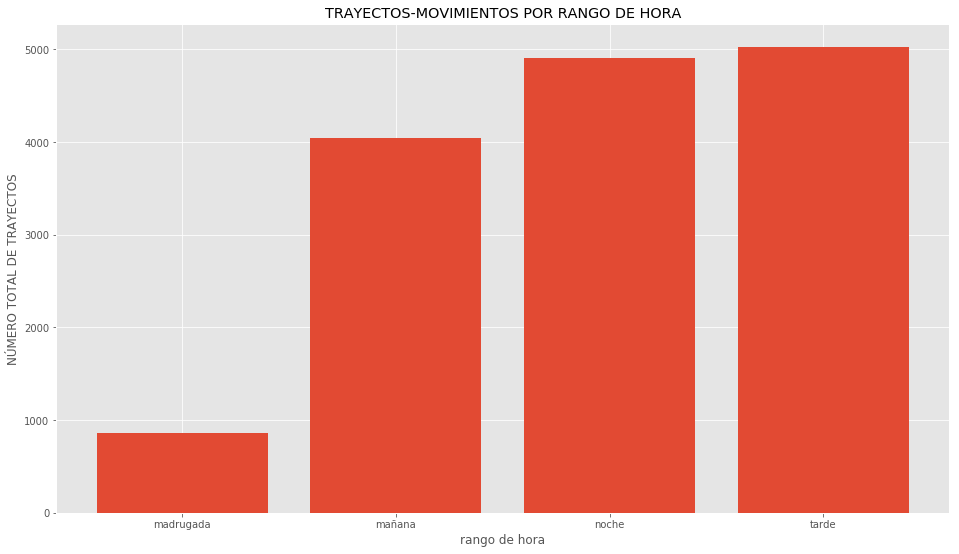

In [0]:
# Histograma de los trayectos por rango de hora
mpg_cyl = bicimad_id['unidad'].groupby(bicimad_id['rango_hora']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS-MOVIMIENTOS POR RANGO DE HORA')
plt.xlabel('rango de hora')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *Por la tarde es el momento dentro del día que se realiza la mayoría de los trayectos y movimientos***


---


### Histograma de los trayectos por tipo de usuario

In [0]:
# TODOS ANALISIS SE REALIZA CON LA TABLA DE TRAYECTOS (bicimad_id)

# Crear variable con los tipos de usuario:

def functype(x):
  if (x==1):
    return "usuario anual"
  elif (x==2):
    return "usuario ocasional"
  elif (x==3):
    return "usuario empresa"
  else:
    return "otro"

bicimad_id['user_type_d'] = bicimad_id['user_type'].apply(lambda x: functype(x))

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

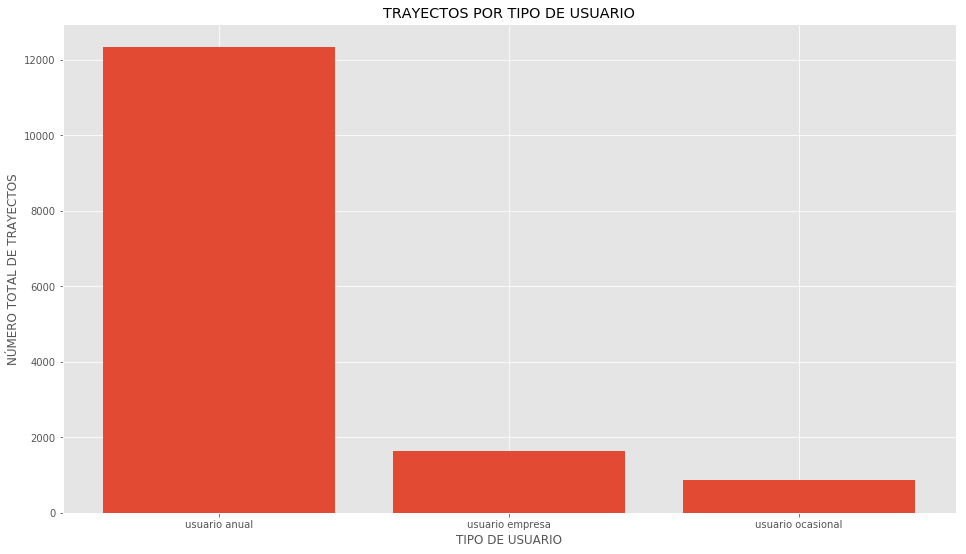

In [0]:
# Histograma de los trayectos por tipo de usuario
mpg_cyl = bicimad_id['unidad'].groupby(bicimad_id['user_type_d']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS POR TIPO DE USUARIO')
plt.xlabel('TIPO DE USUARIO')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *Los usuarios anuales son los que más uso del servicio BiciMAD hacen. Eso significa que, la mayoría del uso se realiza por personas que han sacado la tarjeta anual para utilizar el servicio más a menudo.
A continuación, son los trabajadores y al final los usuarios ocasionales que sacan la tarjeta BiciMAD para utilizarla durante 1, 3 o 5 días (e.g. turistas)***


---


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b617e74a8>,
      dtype=object)

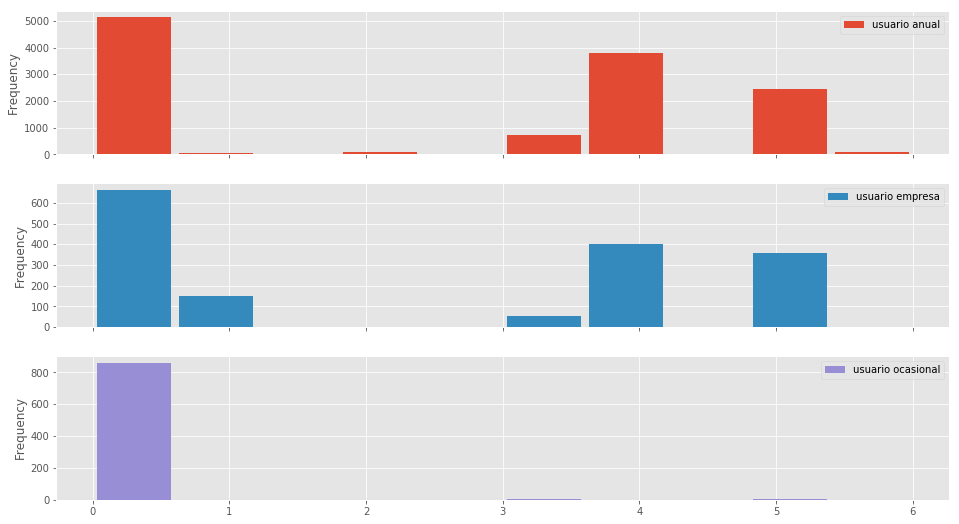

In [0]:
# Histogramas de los trayectos por rango de edad separado por tipo de usuario
bicimad_id.pivot(columns='user_type_d', values='ageRange').plot(kind='hist', subplots=True, rwidth=0.9, align='mid')

### Histograma de los trayectos por edad

In [0]:
# Crear variable con los rangos de edad:
def funcage(x):
  if (x==1):
    return "0-16"
  elif (x==2):
    return "17-18"
  elif (x==3):
    return "19-26"
  elif (x==4):
    return "27-40"
  elif (x==5):
    return "41-65"
  elif (x==6):
    return "66+"
  else:
    return "ND"
bicimad_id['ageRange_d'] = bicimad_id['ageRange'].apply(lambda x: funcage(x))

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

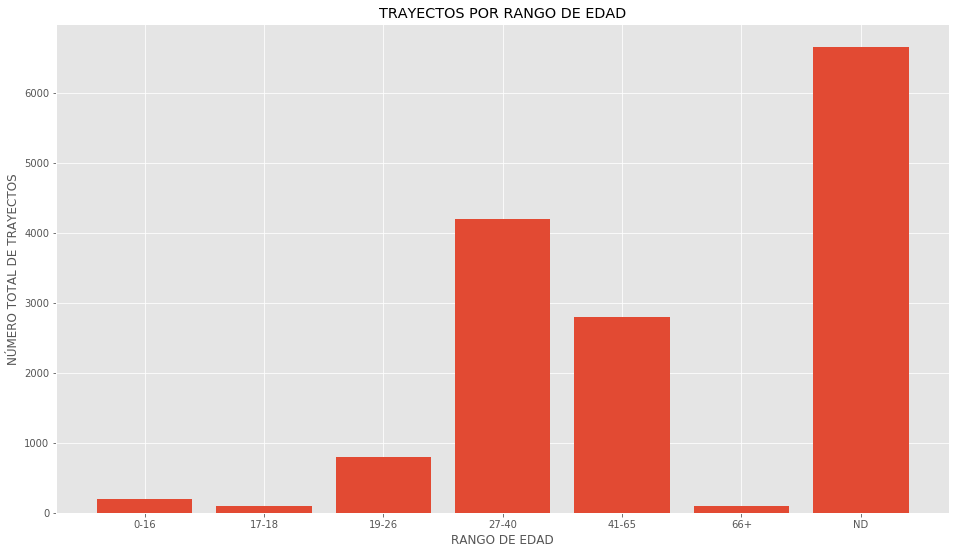

In [0]:
# Histograma de los trayectos por rango de edad

mpg_cyl = bicimad_id['unidad'].groupby(bicimad_id['ageRange_d']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS POR RANGO DE EDAD')
plt.xlabel('RANGO DE EDAD')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *Los usuarios del servicio a su mayoría no definen sus edades (cómo vimos anteriormente la mayoría son los ocasionales) y a continuación vemos que siguen los usuarios de 27 a 40 años.***


---


### Histograma de los trayectos por duración

In [0]:
# Crear variable con los rangos de duración del trayecto
def rango_time(x):
  if (x<=10):
    return "  0-10"
  elif (x>10) and (x<=20):
    return " 10-20"
  elif (x>20) and (x<=30):
    return " 20-30"
  elif (x>30) and (x<=60):
    return " 30-60"
  elif (x>60) and (x<=90):
    return " 60-90"
  elif(x>90) and (x<=120):
    return " 90-120" 
  elif (x>120):
    return "120+"
  else:
    return "missing"
bicimad_id['travel_time_range'] = bicimad_id['travel_time_min'].apply(lambda x: rango_time(x))

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

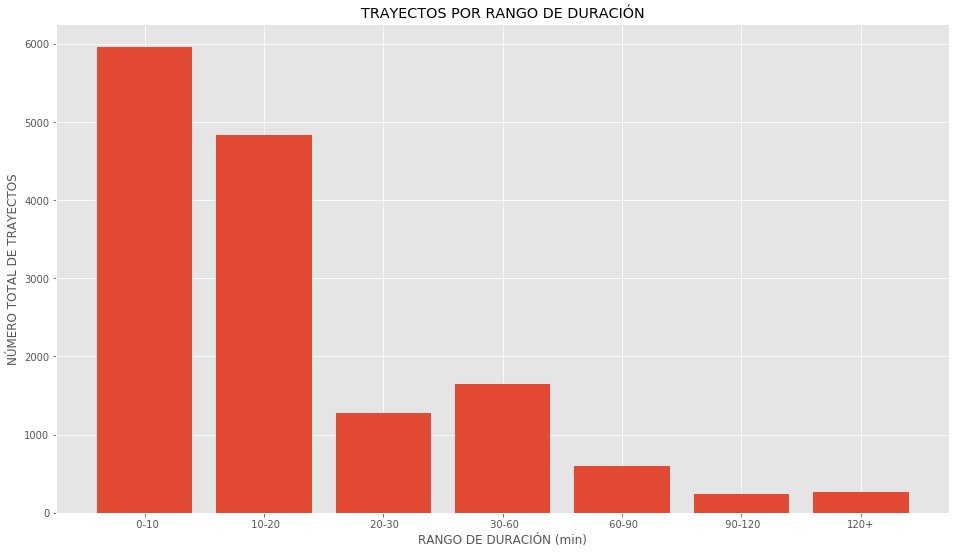

In [0]:
# Histograma de los trayectos por duración

mpg_cyl = bicimad_id['unidad'].groupby(bicimad_id['travel_time_range']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS POR RANGO DE DURACIÓN')
plt.xlabel('RANGO DE DURACIÓN (min)')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *La mayoría de los usuarios utilizan el servicio para corto plazo, hasta 10 minutos. Cómo veremos adelante, son los movimientos de los trabajadores que afectan estos valores ya que se realizan rápido y muchas veces en la misma estación.***


---


In [0]:
bicimad_id.columns

Index(['user_day_code', 'day', 'datesample', 'daysample', 'idplug_station',
       'idunplug_station', 'unidad', 'speed', 'travel_time_min', 'user_type',
       'ageRange', 'weekday', 'business_day', 'day_morning', 'rango_hora',
       'hour', 'user_type_d', 'ageRange_d', 'travel_time_range'],
      dtype='object')

### Histograma de los trayectos por fecha

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

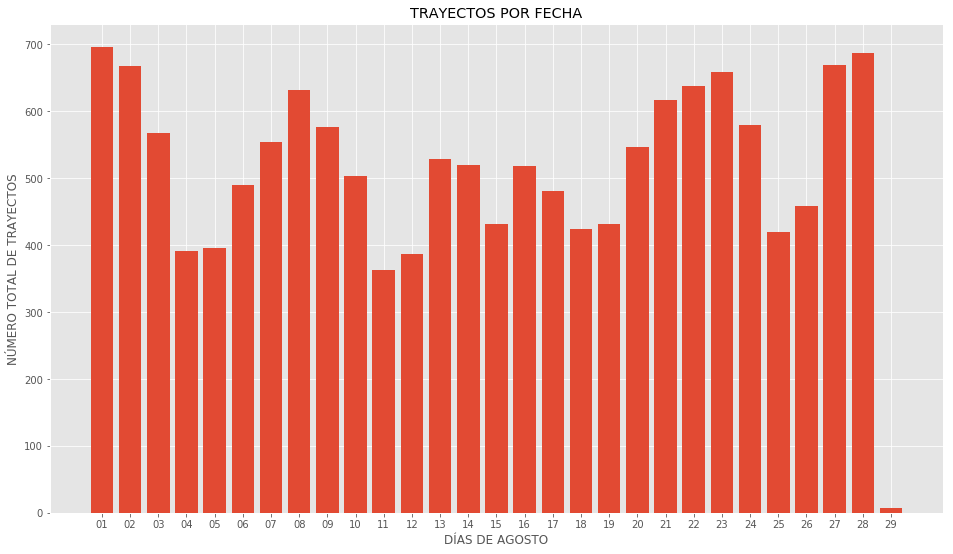

In [0]:
# Histograma de los trayectos por fecha

mpg_cyl = bicimad_id['unidad'].groupby(bicimad_id['day']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS POR FECHA')
plt.xlabel('DÍAS DE AGOSTO')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *El primer día de agosto parece que se realizaron la mayoría de movimientos y trayectos. Un disminución se nota alrededor del festivo de 15 de agosto.***


---


### Histograma de los trayectos por día de semana

In [0]:
# Crear variable "weekday" con el número del día de la semana (valores 0-6 para L-D)
bicimad_id['weekday_d'] = bicimad_id['datesample'].dt.weekday_name

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

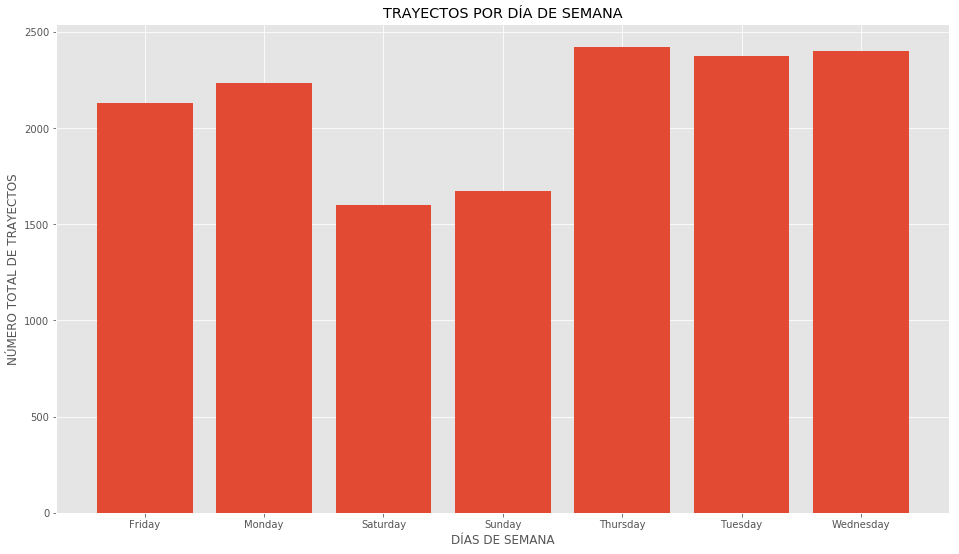

In [0]:
# Histograma de los trayectos por día

mpg_cyl = bicimad_id['unidad'].groupby(bicimad_id['weekday_d']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS POR DÍA DE SEMANA')
plt.xlabel('DÍAS DE SEMANA')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *Los jueves se realizan la mayoría de trayectos y movimientos dentro de la semana de agosto aunque los miercoles y martes también hay movimiento elevado. Durante el fin de semana baja el uso***


---


### Histograma de los trayectos por tipo de día

In [0]:
# Crear variable con los días
def dias_lab(x):
  if (x==1):
    return "Día laborable"
  else:
    return "Fin de semana"
bicimad_id['business_day_d'] = bicimad_id['business_day'].apply(lambda x: dias_lab(x))

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

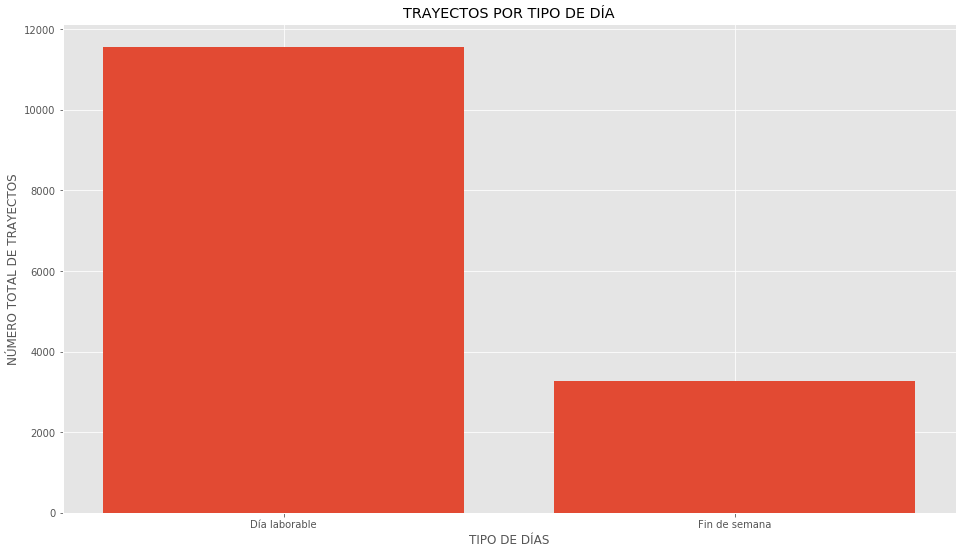

In [0]:
# Histograma de los trayectos por día

mpg_cyl = bicimad_id['unidad'].groupby(bicimad_id['business_day_d']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS POR TIPO DE DÍA')
plt.xlabel('TIPO DE DÍAS')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')

### Histograma de los trayectos por rango de velocidad


In [0]:
# Crear variable con los rangos de la velocidad
def rango_speed(x):
  if (x<=5):
    return " 0"
  elif (x<=10):
    return " 5"
  elif (x<=15):
    return "10"
  elif (x<=20):
    return "15"
  elif (x<=30):
    return "20"
  elif (x<=40):
    return "30" 
  else:
    return "otro"
bicimad_id['speed_range'] = bicimad_id['speed'].apply(lambda x: rango_speed(x))

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

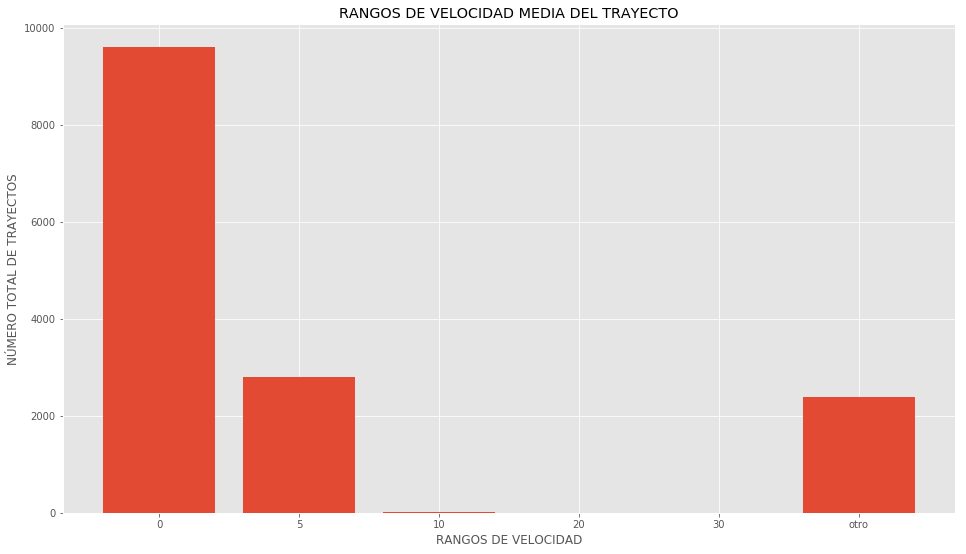

In [0]:
# Histograma de los trayectos por rango de velocidad

mpg_cyl = bicimad_id['unidad'].groupby(bicimad_id['speed_range']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('RANGOS DE VELOCIDAD MEDIA DEL TRAYECTO')
plt.xlabel('RANGOS DE VELOCIDAD')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *Los usuarios del servicio se mueven con bajas velocidades, hasta 5km/h. Por otro lado, como veremos más adelante, la mayoría de esos son los trabajadores que realizan movimientos de las bicicletas y generan registros con velocidad 0 o missing***


---


## HISTOGRAMAS COMBINADOS

###Comparación de edad y duración del trayecto

In [0]:
# COMPARACIÓN DE EDAD Y DURACIÓN DEL TRAYECTO
bicimad_age_time = pd.crosstab(bicimad_id.ageRange_d,bicimad_id.travel_time_range)
print(bicimad_age_time)

travel_time_range    0-10   10-20   20-30   30-60   60-90   90-120  120+
ageRange_d                                                              
0-16                   47      34      34      51      25        0     1
17-18                  32      41       7       8       5        0     1
19-26                 394     239      78      64      12        2     7
27-40                2060    1455     238     268     100       38    42
41-65                1139     902     263     350      73       13    57
66+                    15      51      10      18       1        3     0
ND                   2274    2117     649     885     379      190   160


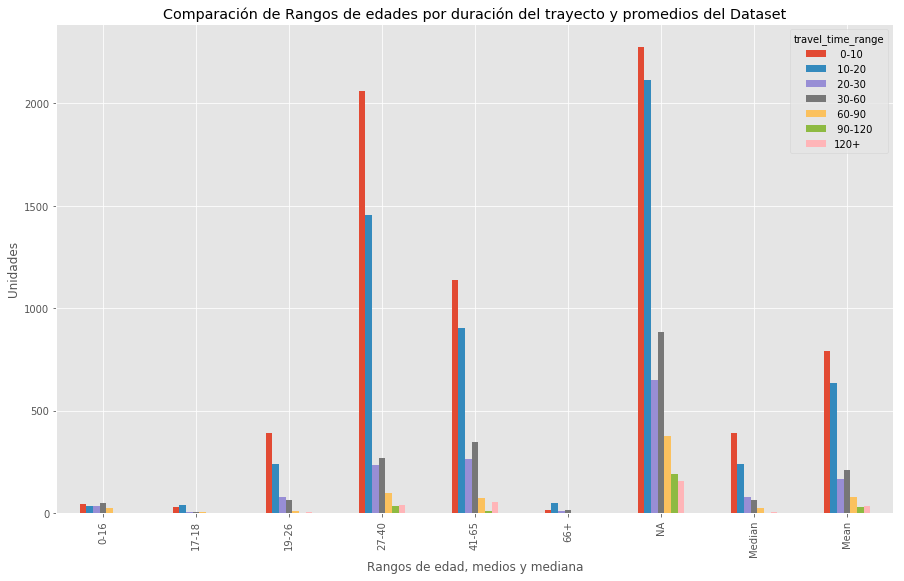

In [0]:
bicimad_age_time.loc[8] = bicimad_age_time.median()
bicimad_age_time.loc[9] = bicimad_age_time.mean()

labels = ['0-16', '17-18', '19-26', '27-40', '41-65', '66+', 'NA', 'Median', 'Mean']
bicimad_age_time.plot(kind='bar', figsize=(15, 9))
plt.xticks(range(9), labels)
plt.xlabel("Rangos de edad, medios y mediana")
plt.ylabel("Unidades")
plt.title("Comparación de Rangos de edades por duración del trayecto y promedios del Dataset")
plt.show()



---


*** *La mayoría de los usuarios se concentran en el grupo de personas que no han definido su edad o tienen entre 27 y 40 años, y han utilizado las bicicletas hasta 20 minutos.***


---


### Comparación de tipo de usuario y duración del trayecto

In [0]:
# COMPARACIÓN DE TIPO DE USUARIO Y DURACIÓN DEL TRAYECTO
bicimad_user_time = pd.crosstab(bicimad_id.user_type_d,bicimad_id.travel_time_range)
print(bicimad_user_time)

travel_time_range    0-10   10-20   20-30   30-60   60-90   90-120  120+
user_type_d                                                             
usuario anual        5686    4532     950     779     239       74    80
usuario empresa       210     188     236     622     208       67    93
usuario ocasional      65     119      93     243     148      105    95


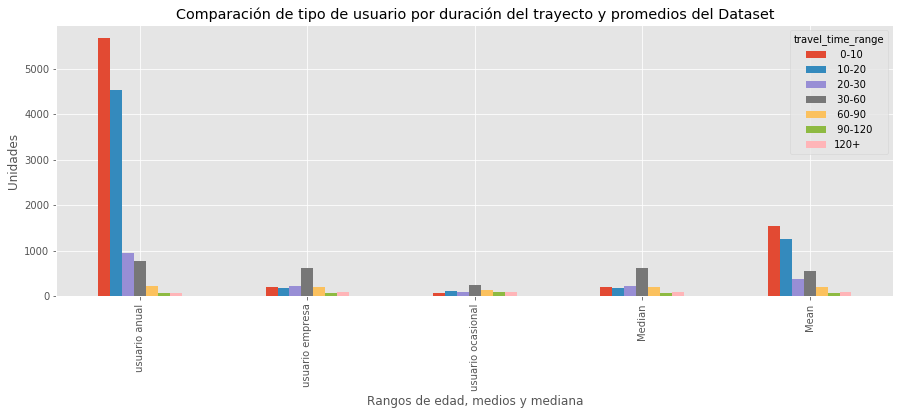

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

bicimad_user_time.loc[4] = bicimad_user_time.median()
bicimad_user_time.loc[5] = bicimad_user_time.mean()

labels = ['usuario anual','usuario empresa','usuario ocasional', 'Median', 'Mean']
bicimad_user_time.plot(kind='bar', figsize=(15, 5))
plt.xticks(range(5), labels)
plt.xlabel("Rangos de edad, medios y mediana")
plt.ylabel("Unidades")
plt.title("Comparación de tipo de usuario por duración del trayecto y promedios del Dataset")
plt.show()



---


*** *Los usuarios anuales utilizan más las bicicletas y además por plazos de hasta 20 minutos.***


---


### Comparación de tipo de usuario y rango de edades






In [0]:
# COMPARACIÓN DE TIPO DE USUARIO Y RANGO DE EDADES
bicimad_edad_user = pd.crosstab(bicimad_id.user_type_d,bicimad_id.ageRange_d)
print(bicimad_edad_user)

ageRange_d         0-16  17-18  19-26  27-40  41-65  66+    ND
user_type_d                                                   
usuario anual        44     94    739   3798   2436   98  5131
usuario empresa     148      0     52    403    359    0   662
usuario ocasional     0      0      5      0      2    0   861


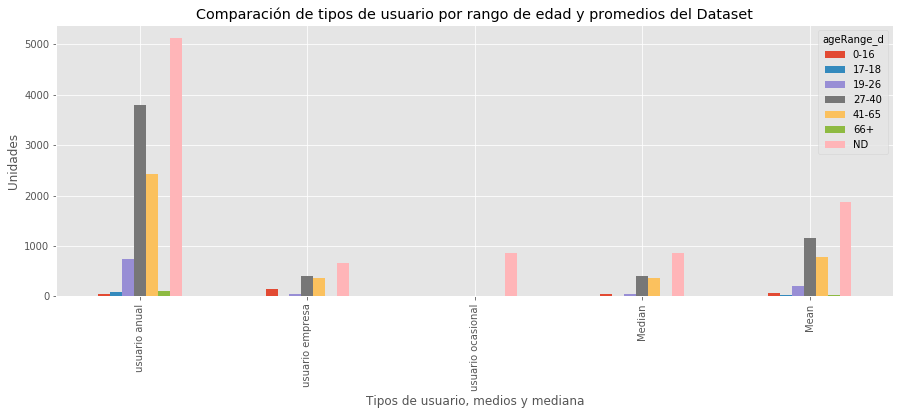

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns



bicimad_edad_user.loc[4] = bicimad_edad_user.median()
bicimad_edad_user.loc[5] = bicimad_edad_user.mean()

labels = ['usuario anual','usuario empresa','usuario ocasional', 'Median', 'Mean']
bicimad_edad_user.plot(kind='bar', figsize=(15, 5))
plt.xticks(range(5), labels)
plt.xlabel("Tipos de usuario, medios y mediana")
plt.ylabel("Unidades")
plt.title("Comparación de tipos de usuario por rango de edad y promedios del Dataset")
plt.show()



---


*** *Aquí se ve que los usuarios anuales hacen más uso que el resto de los tipos de usuarios del servicio. Hay alta concentración en usuarios que no definen su edad y a continuación, son los usuarios de 27 a 40 años***


---


### Comparación de tipo de usuario con velocidad 


In [0]:
# COMPARACIÓN DE TIPO DE USUARIO Y VELOCIDAD
bicimad_user_speed = pd.crosstab(bicimad_id.user_type_d,bicimad_id.speed_range)
print(bicimad_user_speed)

speed_range           0     5  10  20  30  otro
user_type_d                                    
usuario anual      8099  2357   2   1   1  1880
usuario empresa     778   442  18   0   0   386
usuario ocasional   728     9   0   0   0   131


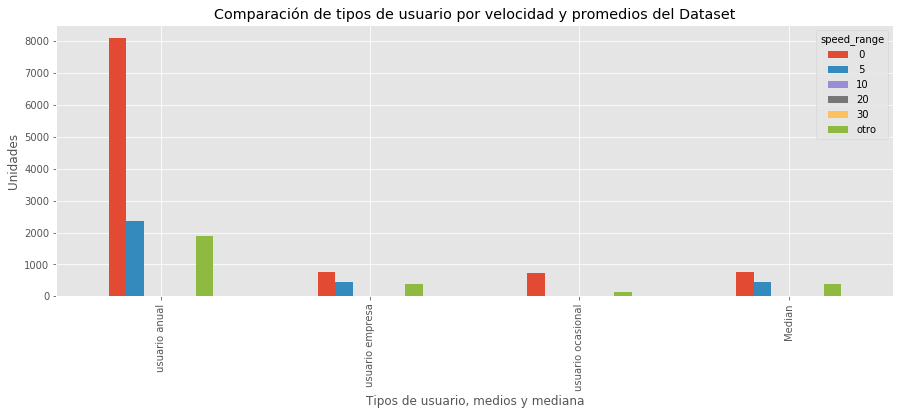

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns



bicimad_user_speed.loc[4] = bicimad_user_speed.median()


labels = ['usuario anual','usuario empresa','usuario ocasional', 'Median']
bicimad_user_speed.plot(kind='bar', figsize=(15, 5))
plt.xticks(range(4), labels)
plt.xlabel("Tipos de usuario, medios y mediana")
plt.ylabel("Unidades")
plt.title("Comparación de tipos de usuario por velocidad y promedios del Dataset")
plt.show()



---


*** *Las bicicletas circulan con baja velocidad, hasta 5km/h***


---


### Comparación de rango de edad con velocidad 

In [0]:
# COMPARACIÓN DE EDAD Y VELOCIDAD
bicimad_edad_speed = pd.crosstab(bicimad_id.ageRange_d,bicimad_id.speed_range)
print(bicimad_edad_speed)

speed_range     0     5  10  20  30  otro
ageRange_d                               
0-16          113    41   0   0   0    38
17-18          65    16   0   0   0    13
19-26         467   196   0   0   0   133
27-40        2565   949  12   0   0   675
41-65        1862   456   2   0   0   477
66+            73    10   0   0   0    15
ND           4460  1140   6   1   1  1046


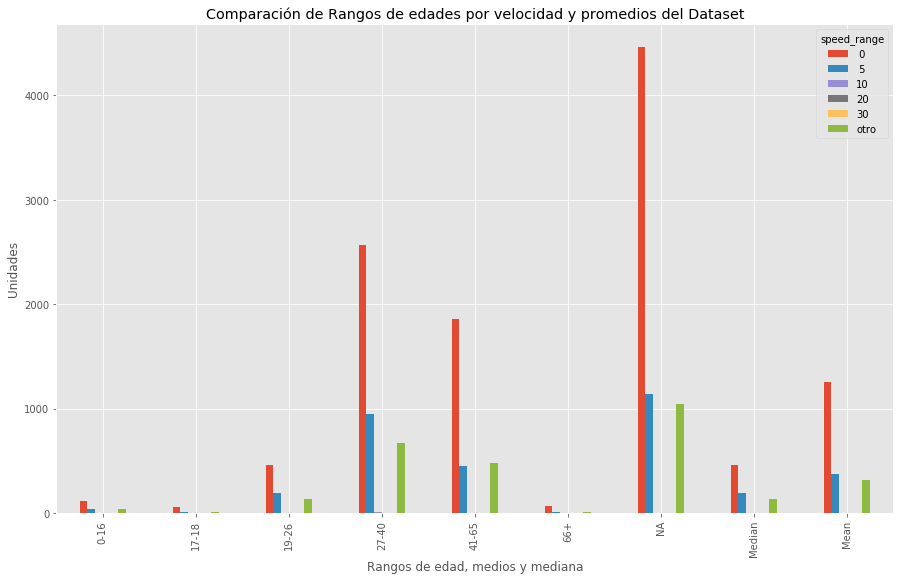

In [0]:
bicimad_edad_speed.loc[8] = bicimad_edad_speed.median()
bicimad_edad_speed.loc[9] = bicimad_edad_speed.mean()

labels = ['0-16', '17-18', '19-26', '27-40', '41-65', '66+', 'NA', 'Median', 'Mean']
bicimad_edad_speed.plot(kind='bar', figsize=(15, 9))
plt.xticks(range(9), labels)
plt.xlabel("Rangos de edad, medios y mediana")
plt.ylabel("Unidades")
plt.title("Comparación de Rangos de edades por velocidad y promedios del Dataset")
plt.show()

### Movimiento de los trabajadores a lo largo del día 

Text(0, 0.5, 'NÚMERO TOTAL DE MOVIMIENTOS')

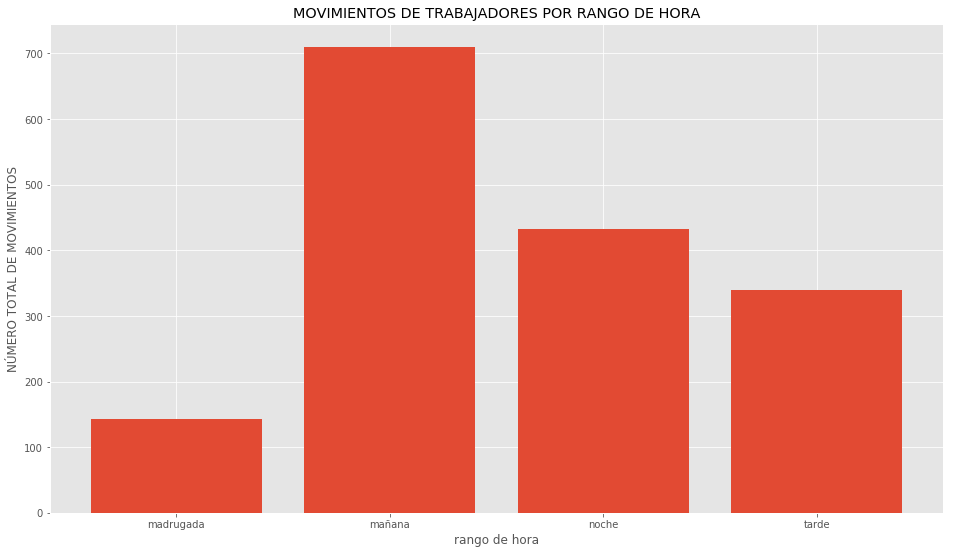

In [0]:
bicimad_id_trabajadores = bicimad_id[bicimad_id['user_type'] == 3]
# Histograma de los movimientos de trabajadores por horas
mpg_cyl = bicimad_id_trabajadores['unidad'].groupby(bicimad_id_trabajadores['rango_hora']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('MOVIMIENTOS DE TRABAJADORES POR RANGO DE HORA')
plt.xlabel('rango de hora')
plt.ylabel('NÚMERO TOTAL DE MOVIMIENTOS')



---


*** *Los trabajadores de BiciMAD realizan la mayoría de sus movimientos durante la mañana.***


---


### Movimiento de los trabajadores por horas 

Text(0, 0.5, 'NÚMERO TOTAL DE MOVIMIENTOS')

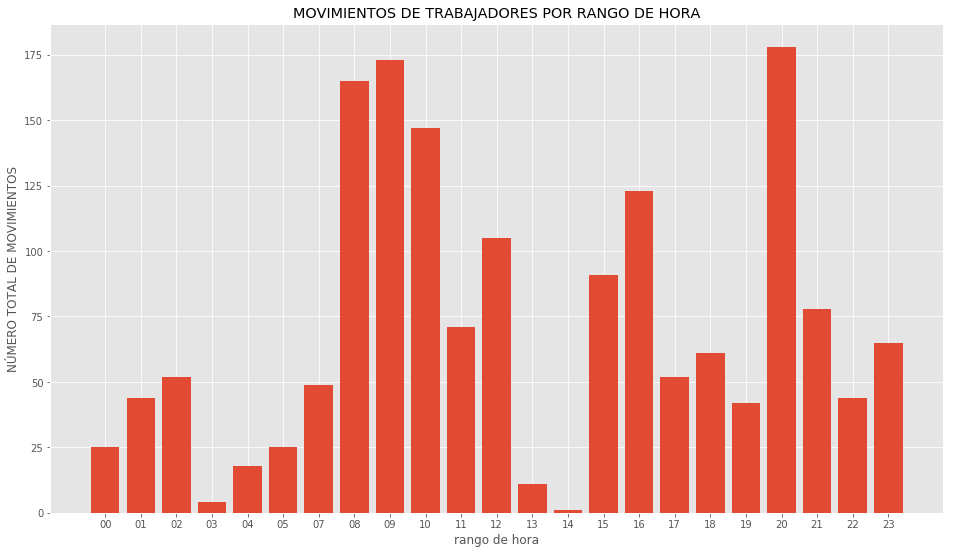

In [0]:
mpg_cyl = bicimad_id_trabajadores['unidad'].groupby(bicimad_id_trabajadores['hour']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('MOVIMIENTOS DE TRABAJADORES POR RANGO DE HORA')
plt.xlabel('rango de hora')
plt.ylabel('NÚMERO TOTAL DE MOVIMIENTOS')



---


*** *Los trabajadores de BiciMAD realizan la mayoría de sus movimientos a las 20.00 por la tarde o entre las 8 y 10 por la mañana.***


---


###Trayectos de los usuarios a lo largo del día

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

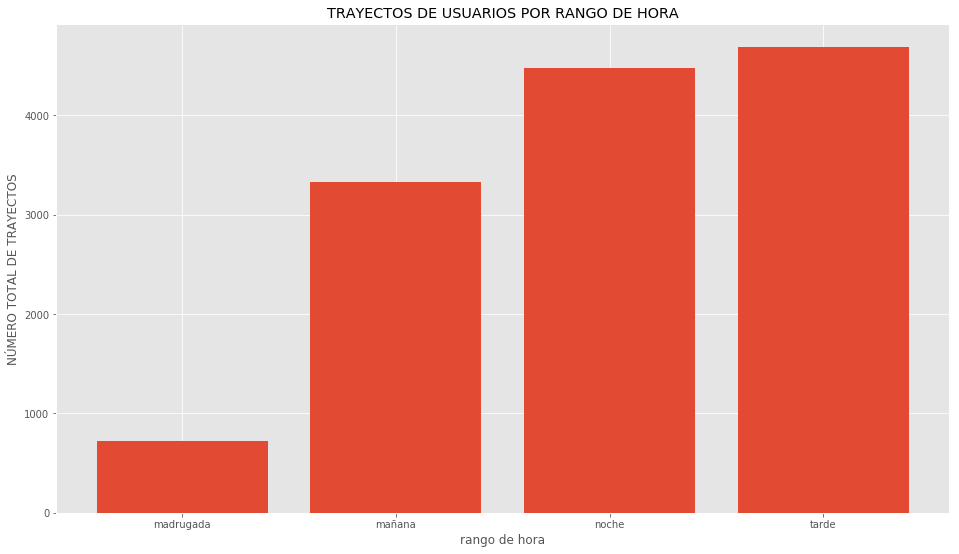

In [0]:
bicimad_id_usuario = bicimad_id[bicimad_id['user_type'] < 3]
# Histograma de los trayectos de usuarios por rango de hora
mpg_cyl = bicimad_id_usuario['unidad'].groupby(bicimad_id_usuario['rango_hora']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS DE USUARIOS POR RANGO DE HORA')
plt.xlabel('rango de hora')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *Los usuarios de BiciMAD realizan la mayoría de sus trayectos durante la tarde.***


---


### Trayectos de los usuarios por hora 

Text(0, 0.5, 'NÚMERO TOTAL DE TRAYECTOS')

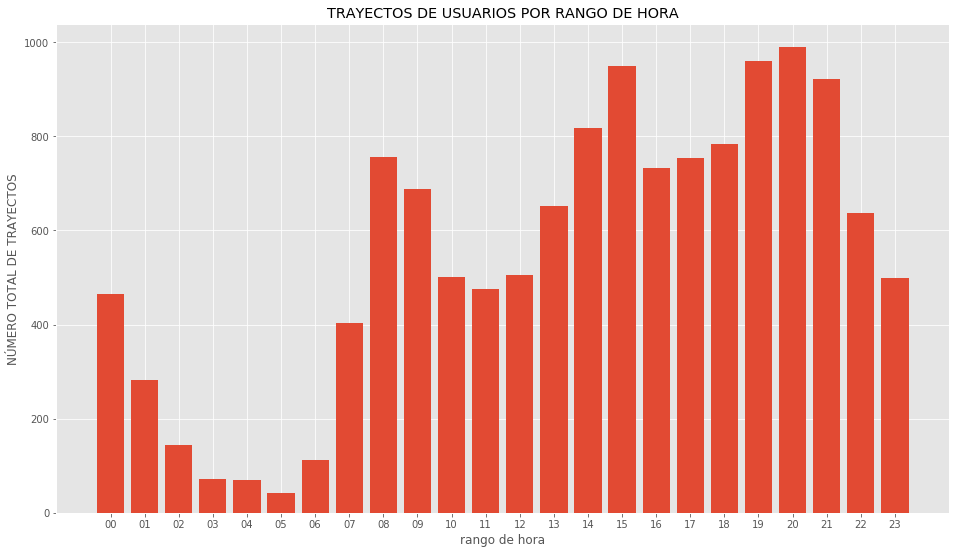

In [0]:
bicimad_id_usuario = bicimad_id[bicimad_id['user_type'] < 3]
# Histograma de los trayectos de usuarios por rango de hora
mpg_cyl = bicimad_id_usuario['unidad'].groupby(bicimad_id_usuario['hour']).count()
plt.bar(mpg_cyl.index, mpg_cyl.values)
plt.title('TRAYECTOS DE USUARIOS POR RANGO DE HORA')
plt.xlabel('rango de hora')
plt.ylabel('NÚMERO TOTAL DE TRAYECTOS')



---


*** *Los usuarios de BiciMAD realizan la mayoría de sus trayectos entre las 19.00 y 21.00 por la tarde o sobre las 15.00 pronto, después del horario laboral.***


---


###Trayectos de usuarios por estaciones de partida y llegada dentro del Retiro


In [0]:
bicimad_id_usuario_retiro = bicimad_id_usuario[bicimad_id_usuario['idplug_station'].isin([64,73,74,78,79,90,107])]
bicimad_id_usuario_retiro=bicimad_id_usuario_retiro.rename(columns={'idplug_station':'estación_llegada','idunplug_station':'estación_partida'})
bicimad_id_usuario_retiro_cros = pd.crosstab(bicimad_id_usuario_retiro.estación_partida,bicimad_id_usuario_retiro.estación_llegada)
print(bicimad_id_usuario_retiro_cros)

estación_llegada  64   73   74   78   79   90   107
estación_partida                                   
64                343   47   27   45   62   96    9
73                 47   93   19   22   10   84    7
74                 36   30   72   24   47   26    5
78                 67   34   13   92    9   36    7
79                 68    8   31   40   40   24    6
90                 62   48   37   20   43  185   10
107                 8    4    6    9    5    5   15


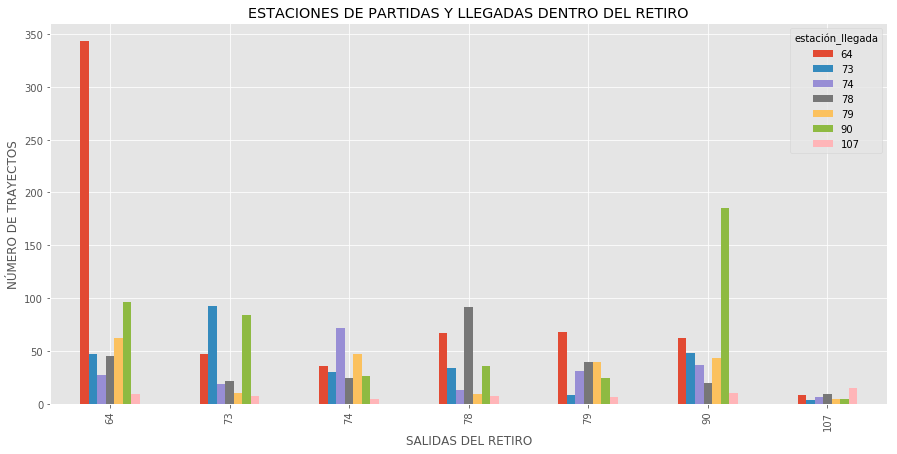

In [0]:
labels = ['64', '73', '74', '78', '79', '90', '107']
bicimad_id_usuario_retiro_cros.plot(kind='bar', figsize=(15, 7))
plt.xticks(range(7), labels)
plt.xlabel("SALIDAS DEL RETIRO")
plt.ylabel("NÚMERO DE TRAYECTOS")
plt.title("ESTACIONES DE PARTIDAS Y LLEGADAS DENTRO DEL RETIRO")
plt.show()



---


*** *Los usuarios de BiciMAD que han salido de y terminado al Retiro, han realizado los trayectos en las estaciones 64 y 90 (partida y llegada en la misma estación)***


---


###Trayectos de usuarios, desde el Retiro y hacía fuera de él

In [0]:
#estaciones fuera de Retiro
bicimad_id_usuario_retiro_mas = bicimad_id_usuario[~bicimad_id_usuario['idplug_station'].isin([64,73,74,78,79,90,107])]
bicimad_id_usuario_retiro_mas=bicimad_id_usuario_retiro_mas.rename(columns={'idplug_station':'estación_llegada','idunplug_station':'estación_partida'})
#Hacer un groupby para las estaciones de partida y llegada y encontrar de cada una dónde dejan las bicis con más frequencia
bicimad_id_usuario_retiro_mas_cros = bicimad_id_usuario_retiro_mas.groupby(['estación_partida','estación_llegada']).agg({'unidad':'sum'})
#Para cada salida desde el Retiro encontrar las 3 primeras llegadas más frecuentes
bicimad_id_usuario_retiro_mas_cros_g = bicimad_id_usuario_retiro_mas_cros['unidad'].groupby(level=0, group_keys=False)
bicimad_id_usuario_retiro_mas_cros_g.nlargest(3)

estación_partida  estación_llegada
64                2                    68
                  1                    65
                  75                   55
73                57                   42
                  46                   36
                  171                  27
74                84                  101
                  83                   70
                  82                   61
78                89                   23
                  166                  22
                  38                   21
79                103                  83
                  108                  59
                  77                   34
90                3                    72
                  128                  68
                  99                   63
107               175                  25
                  129                  21
                  56                   19
Name: unidad, dtype: int64



---


*** *Para cada estación de partida el Retiro, se presentan sus 3 estaciones de llegada fuera del Retiro con más frequencia.***


---


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


tipo_llegada      Dentro de Retiro  Fuera de Retiro
estación_partida                                   
64                             629             2408
73                             282             1191
74                             240             1705
78                             258              921
79                             217             1617
90                             405             2681
107                             52              602


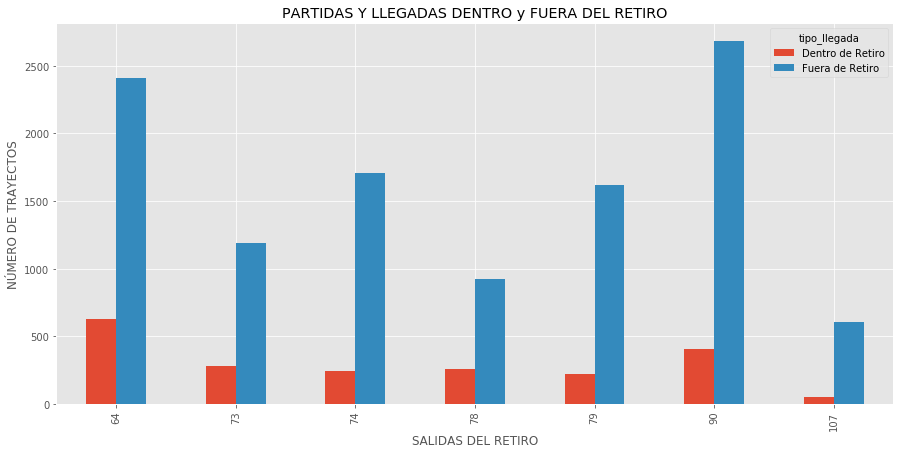

In [57]:
def in_out(x):
  if x in (64,73,74,78,79,90,107):
     return "Dentro de Retiro"
  else:
      return "Fuera de Retiro"
bicimad_id_usuario['tipo_llegada'] = bicimad_id_usuario['idplug_station'].apply(lambda x: in_out(x))

bicimad_id_usuario_inout=bicimad_id_usuario.rename(columns={'idunplug_station':'estación_partida'})
bicimad_id_usuario_inout_cros = pd.crosstab(bicimad_id_usuario_inout.estación_partida,bicimad_id_usuario_inout.tipo_llegada)
print(bicimad_id_usuario_inout_cros)

labels = ['64', '73', '74', '78', '79', '90', '107']
bicimad_id_usuario_inout_cros.plot(kind='bar', figsize=(15, 7))
plt.xticks(range(7), labels)
plt.xlabel("SALIDAS DEL RETIRO")
plt.ylabel("NÚMERO DE TRAYECTOS")
plt.title("PARTIDAS Y LLEGADAS DENTRO y FUERA DEL RETIRO")
plt.show()



---


*** *Para cada estación de salida del Retiro, se representa el número de llegadas dentro y fuera de él. La mayoría de los trayectos que salen desde el Retiro, acaban fuera de él.***


---


###Movimientos de trabajadores estaciones dentro del Retiro


In [58]:
bicimad_id_trabajadores_retiro = bicimad_id_trabajadores[bicimad_id_trabajadores['idplug_station'].isin([64,73,74,78,79,90,107])]
bicimad_id_trabajadores_retiro=bicimad_id_trabajadores_retiro.rename(columns={'idplug_station':'estación_dónde_deja_bici','idunplug_station':'estación_dónde_mueve_bici'})
bicimad_id_trabajadores_retiro_cros = pd.crosstab(bicimad_id_trabajadores_retiro.estación_dónde_mueve_bici,bicimad_id_trabajadores_retiro.estación_dónde_deja_bici)
print(bicimad_id_trabajadores_retiro_cros)

estación_dónde_deja_bici   64   73   74   78   79   90   107
estación_dónde_mueve_bici                                   
64                          34    4    2    0    6   10    0
73                           0   23    0    0    6    8    0
74                           5    0   33    2    0    0    0
78                           8    0    0   30    1    0    0
79                           1   10    0    0   11    0    0
90                           4    0    5    1    0   25    0
107                          0    0    5    0    0    0   20


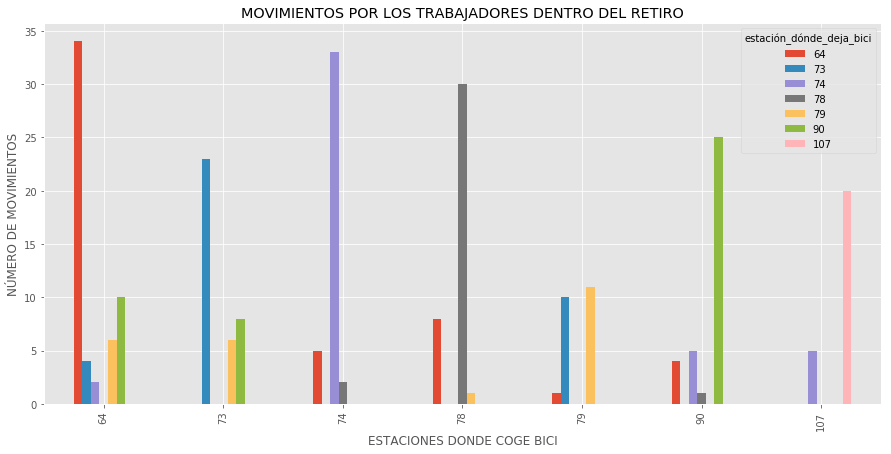

In [59]:
labels = ['64', '73', '74', '78', '79', '90', '107']
bicimad_id_trabajadores_retiro_cros.plot(kind='bar', figsize=(15, 7))
plt.xticks(range(7), labels)
plt.xlabel("ESTACIONES DONDE COGE BICI")
plt.ylabel("NÚMERO DE MOVIMIENTOS")
plt.title("MOVIMIENTOS POR LOS TRABAJADORES DENTRO DEL RETIRO")
plt.show()



---


*** *Los movimientos que realizan los trabajadores que cogen las bicicletas desde el Retiro, en su mayoría las dejan a la misma estación. Se podía realizar un estudio más detallado para ver si lo hacen para cambiar base o solo para realizar revisión***


---


In [60]:
#Muestra de casos de movimientos de trabajadores que sacaron bici de una estación y la dejaron en la misma
bicimad_id_trabajadores_muestra = bicimad_id_trabajadores_retiro[bicimad_id_trabajadores_retiro['estación_dónde_deja_bici'] == bicimad_id_trabajadores_retiro['estación_dónde_mueve_bici'] ]
bicimad_id_trabajadores_muestra.describe()

#muchos missing de velocidad y lo que queda es casi todo 0
#duracion muy corta

,estación_dónde_deja_bici,estación_dónde_mueve_bici,unidad,speed,travel_time_min,user_type,ageRange,weekday,business_day,day_morning
count,176.000000,176.000000,176.0,12.000000,176.000000,176.0,176.000000,176.000000,176.000000,176.000000
mean,78.954545,78.954545,1.0,0.355238,1.166288,3.0,3.238636,3.181818,0.625000,2.573864
std,12.657609,12.657609,0.0,0.528749,7.194788,0.0,1.933136,1.897640,0.485504,0.852022
min,64.000000,64.000000,1.0,0.000000,0.033333,3.0,0.000000,0.000000,0.000000,1.000000
25%,73.000000,73.000000,1.0,0.000000,0.116667,3.0,1.000000,1.750000,0.000000,2.000000
50%,74.000000,74.000000,1.0,0.078333,0.183333,3.0,4.000000,3.000000,1.000000,2.000000
75%,90.000000,90.000000,1.0,0.501250,0.408333,3.0,5.000000,5.000000,1.000000,3.000000
max,107.000000,107.000000,1.0,1.702857,94.050000,3.0,5.000000,6.000000,1.000000,4.000000




---


*** *Aquí se ve que hay 176 movimientos de trabajadores que cogen y dejan las bicicletas en la misma estación. En estos casos, los movimientos se realizan con una velocidad de 0 o incluso valor missing (total de registros con valor en velocidad hay solo 12 y el resto son missings). La velocidad missing en estos casos tiene sentido ya que no se utilizan las bicicletas en sí. Además, se confirma esto con la baja duración del movimiento.***


---


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


tipo_donde_deja_bici       Dentro de Retiro  Fuera de Retiro
estación_dónde_mueve_bici                                   
64                                       56              389
73                                       37              235
74                                       40              116
78                                       39              132
79                                       22              305
90                                       35              165
107                                      25               28


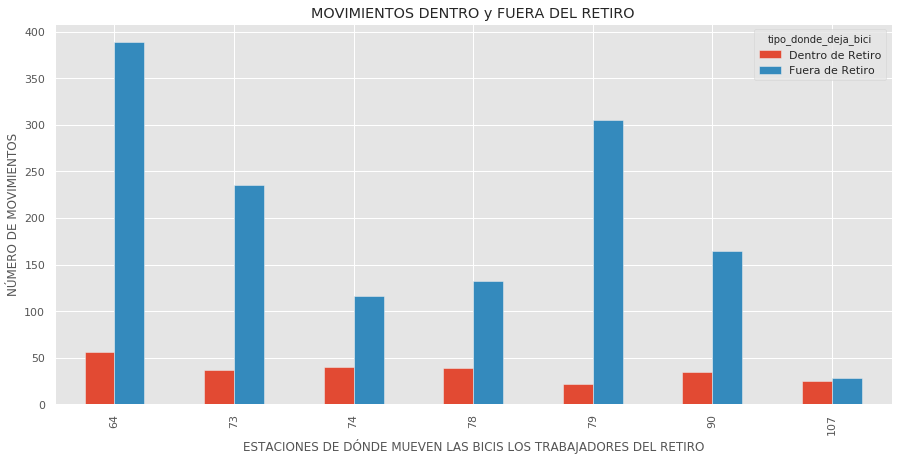

In [0]:
bicimad_id_trabajadores['tipo_donde_deja_bici'] = bicimad_id_trabajadores['idplug_station'].apply(lambda x: in_out(x))

bicimad_id_trabajadores_inout=bicimad_id_trabajadores.rename(columns={'idunplug_station':'estación_dónde_mueve_bici'})
bicimad_id_trabajadores_inout_cros = pd.crosstab(bicimad_id_trabajadores_inout.estación_dónde_mueve_bici,bicimad_id_trabajadores_inout.tipo_donde_deja_bici)
print(bicimad_id_trabajadores_inout_cros)

labels = ['64', '73', '74', '78', '79', '90', '107']
bicimad_id_trabajadores_inout_cros.plot(kind='bar', figsize=(15, 7))
plt.xticks(range(7), labels)
plt.xlabel("ESTACIONES DE DÓNDE MUEVEN LAS BICIS LOS TRABAJADORES DEL RETIRO")
plt.ylabel("NÚMERO DE MOVIMIENTOS")
plt.title("MOVIMIENTOS DENTRO y FUERA DEL RETIRO")
plt.show()



---


*** *Para cada estación de salida del Retiro, se representa el número de llegadas dentro y fuera de él. La mayoría de los movimientos se realizan desde el Retiro, y las dejan fuera de él.***


---



---


### b. Estudio de los estadísticos principales

In [0]:
# Calcular los estadísticos principales de todos los trayectos que se realizaron el agosto del 2018
bicimad_id.describe()

,idplug_station,idunplug_station,unidad,speed,travel_time_min,user_type,ageRange,weekday,business_day,day_morning
count,14832.000000,14832.000000,14832.0,12435.000000,14832.000000,14832.000000,14832.000000,14832.000000,14832.000000,14832.000000
mean,83.009574,77.745078,1.0,4.010121,23.532875,1.277508,2.302117,2.762945,0.779598,2.941882
std,44.268030,11.104111,0.0,1.453436,86.221505,0.647697,2.169340,1.921010,0.414532,0.912603
min,1.000000,64.000000,1.0,0.000000,0.016667,1.000000,0.000000,0.000000,0.000000,1.000000
25%,53.000000,73.000000,1.0,3.026333,7.633333,1.000000,0.000000,1.000000,1.000000,2.000000
50%,80.000000,78.000000,1.0,3.954000,11.900000,1.000000,3.000000,3.000000,1.000000,3.000000
75%,111.000000,90.000000,1.0,4.896125,21.658333,1.000000,4.000000,4.000000,1.000000,4.000000
max,175.000000,107.000000,1.0,30.720000,8030.233333,3.000000,6.000000,6.000000,1.000000,4.000000


     
**MISSING VALUES**



In [0]:
# Estudiar los valores missing de las variables que presentan nulls
print(bicimad_id.isnull().sum())

day                     0
datesample              0
daysample               0
idplug_station          0
idunplug_station        0
unidad                  0
speed                2397
travel_time_min         0
user_type               0
ageRange                0
weekday                 0
business_day            0
day_morning             0
rango_hora              0
hour                    0
user_type_d             0
ageRange_d              0
travel_time_range       0
weekday_d               0
business_day_d          0
speed_range             0
dtype: int64




---


*** *De todas la variables de nuestro dataframe inicial, solo en la velocidad hay valores missings. Cómo vimos anteriormente, los movimientos de los trabajadores generan muchos registros con velocidad missing***


---

In [0]:
# Para estudiar los missings de la variable "speed" (la única que representa), vemos que la media y mediana están muy cerca (4 y 3,9 respectivamente) así que rellenamos los missings con la mediana
median = bicimad_id['speed'].median()
bicimad_id['speed'].fillna(median, inplace=True)



---


### c. Identificación de outliers y Box-plots

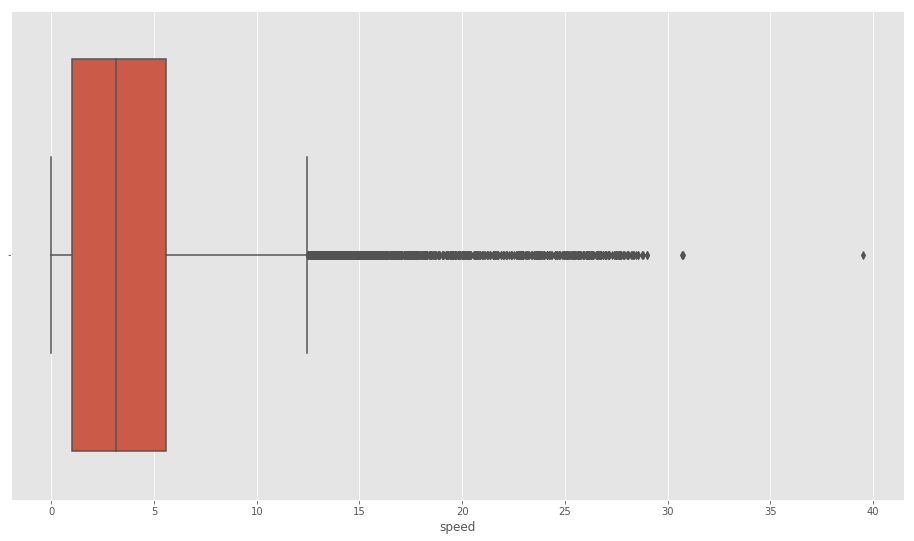

In [0]:
# De todas las variables las que pueden tener outliers son la velocidad (speed) y la duración del trayecto (travel_time).
# El resto de las variables son numéricas pero categorizadas
#https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html
import seaborn as sns
sns.boxplot(x=bicimad['speed'])

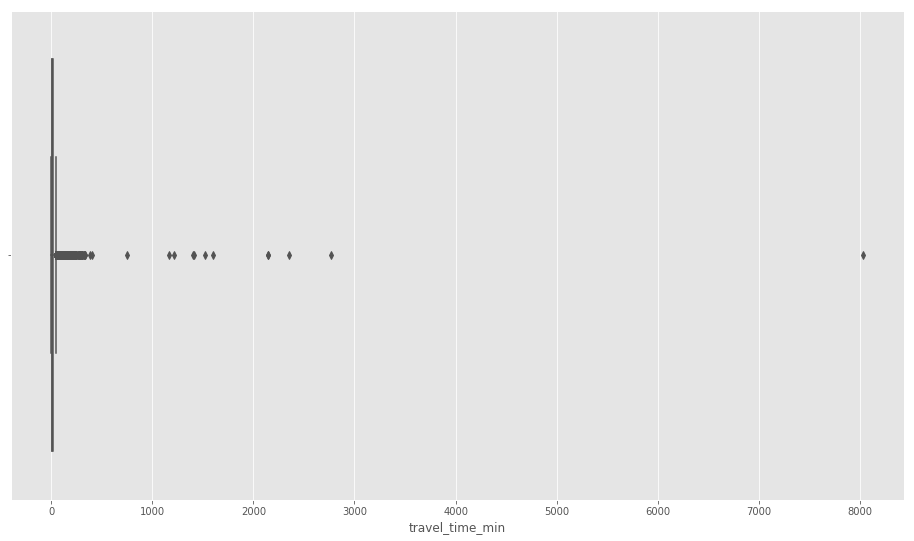

In [0]:
import seaborn as sns
sns.boxplot(x=bicimad_id['travel_time_min'])

In [64]:
#Normalizamos las variables speed y travel time para su mejor analisis
import numpy as np
bicimad_norm = bicimad_id.loc[:,['travel_time_min', 'speed', 'user_type', 'ageRange','rango_hora','weekday' ]]

bicimad_norm['travel_time_norm'] = np.log(bicimad_norm['travel_time_min'])
bicimad_norm['speed_norm'] = np.log(bicimad_norm['speed'])
bicimad_norm['speed_norm'].fillna(median, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


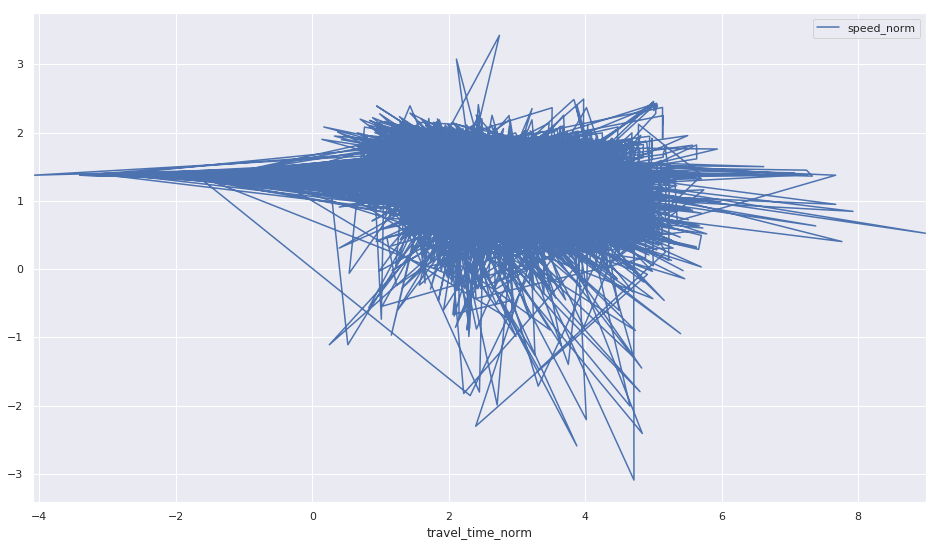

In [0]:
## matriz de dispersion con los datos de speed y travel time normalizados 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
bicimad_norm.plot(x='travel_time_norm', y='speed_norm', style=['b'])


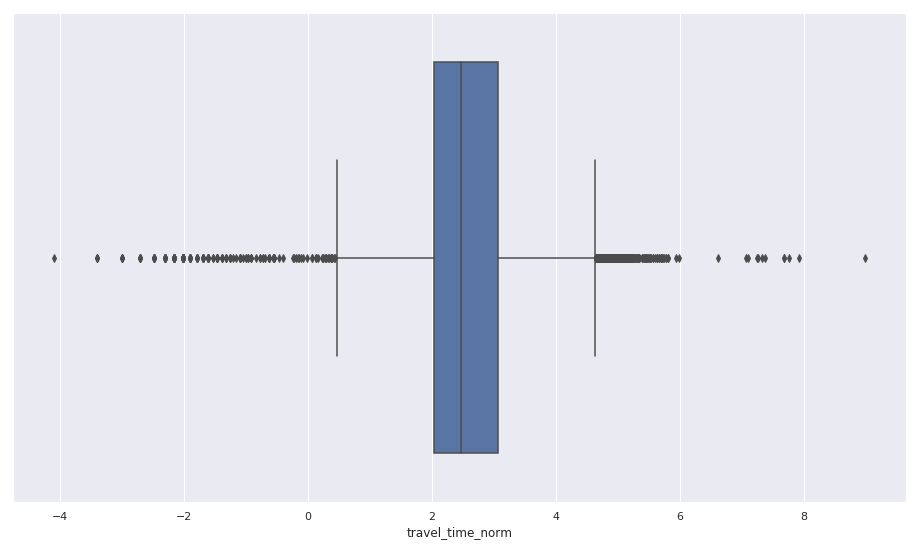

In [0]:
sns.boxplot(x=bicimad_norm['travel_time_norm'])

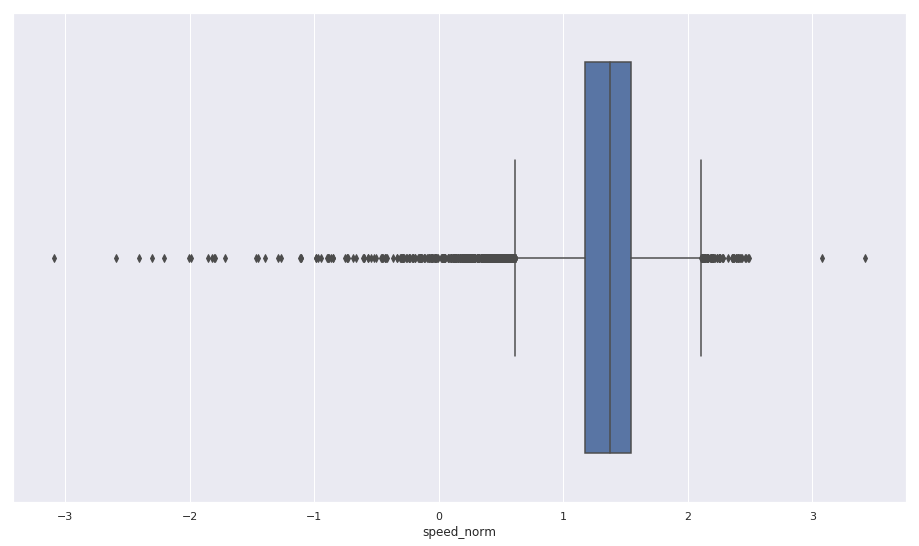

In [0]:
sns.boxplot(x=bicimad_norm['speed_norm'])

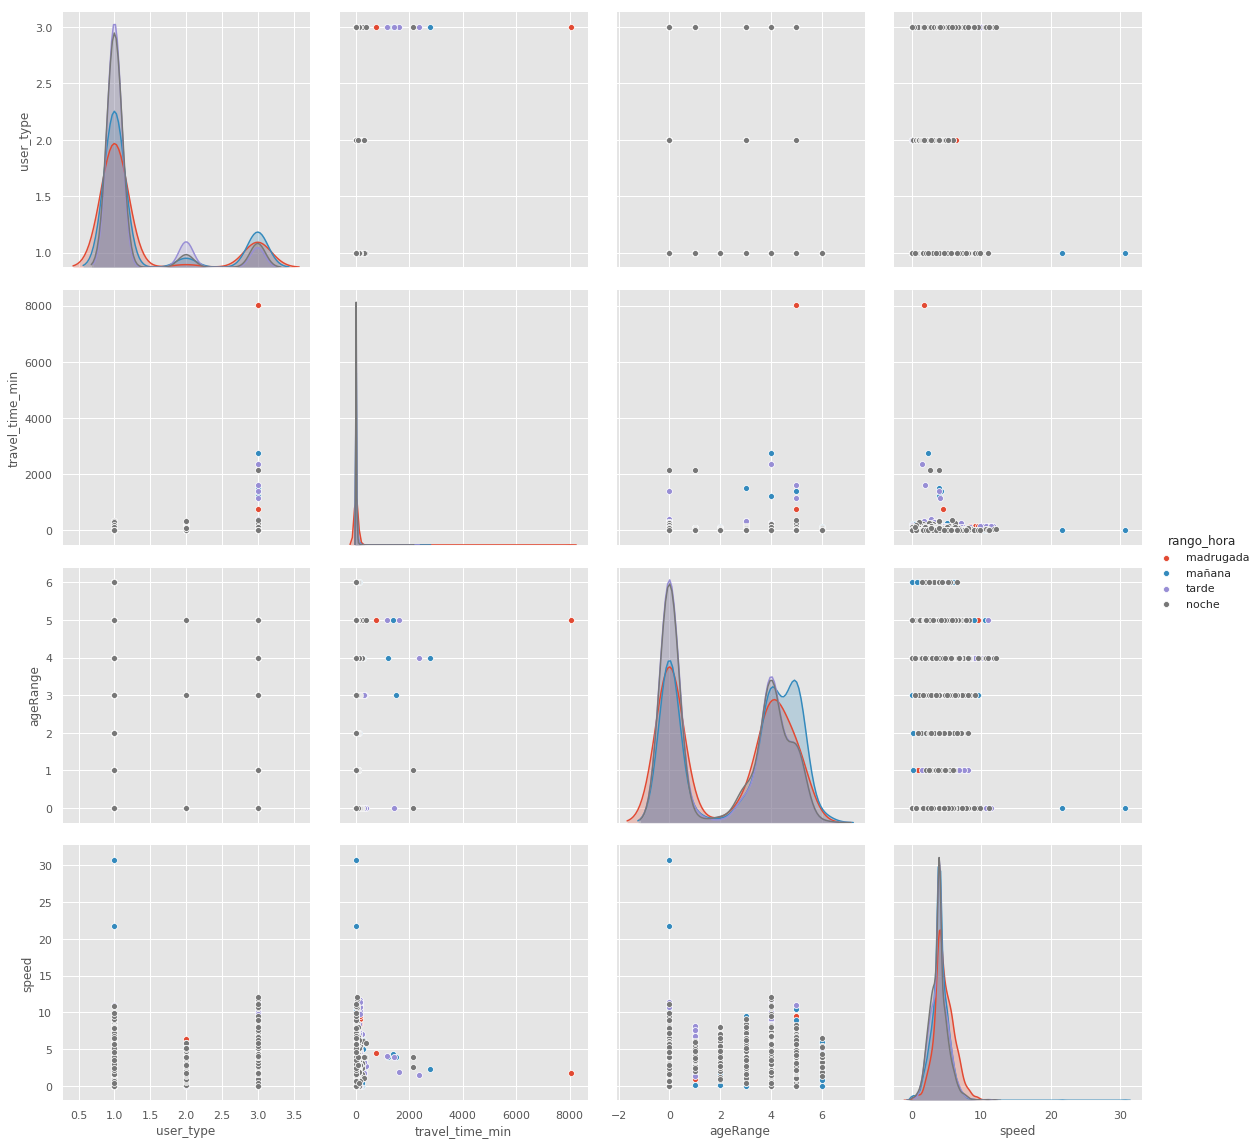

In [0]:
#Scatter Matrix rango hora
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

sb.pairplot(bicimad_id.dropna(), hue='rango_hora',height=4,vars=["user_type","travel_time_min","ageRange",'speed' ],kind='scatter')

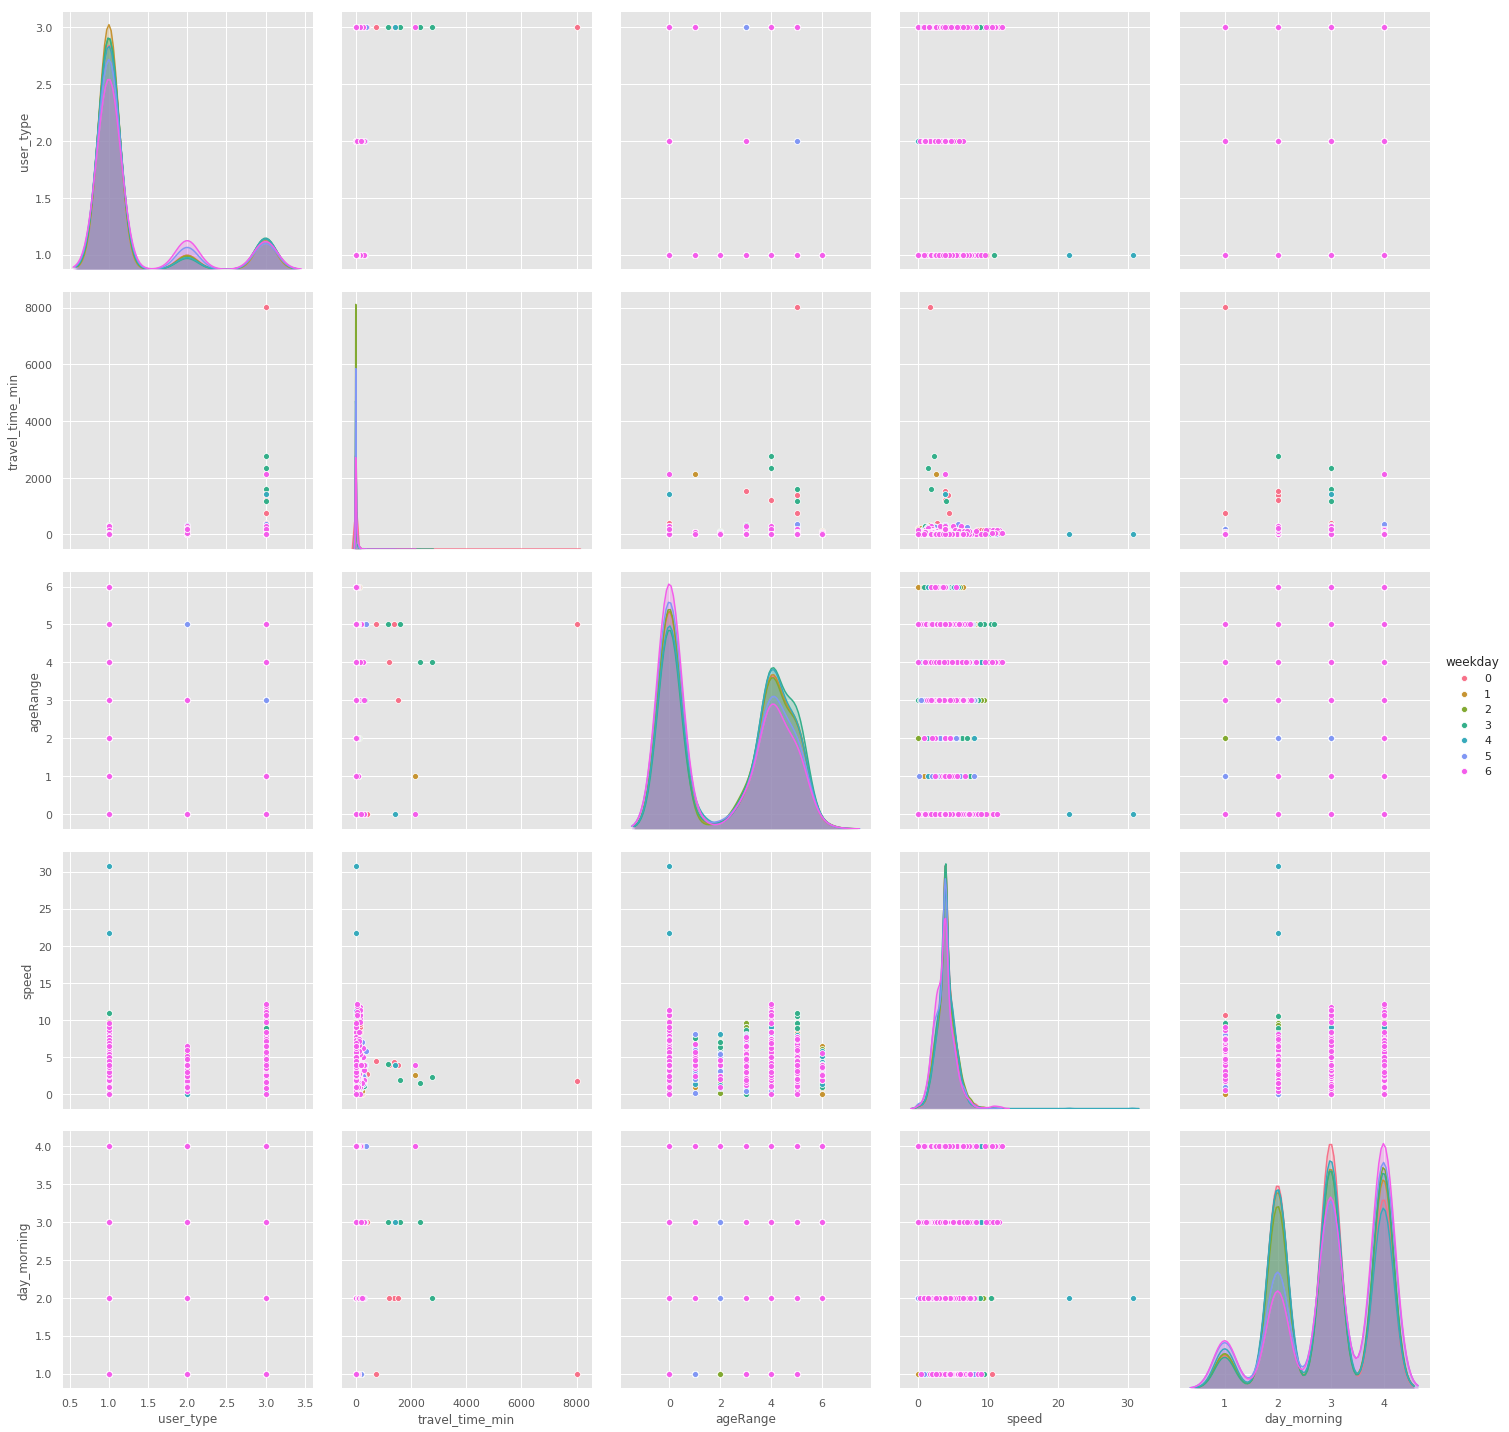

In [0]:
#Scatter Matrix laborable (1) o finde semana (0)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min



sb.pairplot(bicimad_id.dropna(), hue='weekday',palette='husl',height=4,vars=["user_type","travel_time_min","ageRange",'speed','day_morning' ],kind='scatter')

In [65]:
#QUITAMOS OUTLIERS
Q1 = bicimad_norm.quantile(0.25)
Q3 = bicimad_norm.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

bicimad_norm_out = bicimad_norm[~((bicimad_norm < (Q1 - 1.5* IQR)) |(bicimad_norm > (Q3 + 1.5 * IQR))).any(axis=1)]
bicimad_norm_out.shape

travel_time_min     14.025000
speed                1.463512
user_type            0.000000
ageRange             4.000000
weekday              3.000000
travel_time_norm     1.042865
speed_norm           0.373716
dtype: float64


(11061, 8)

In [0]:
#funcion para quitar nan
def clean(serie):
    output = serie[(np.isnan(serie) == False) & (np.isinf(serie) == False)]
    return output

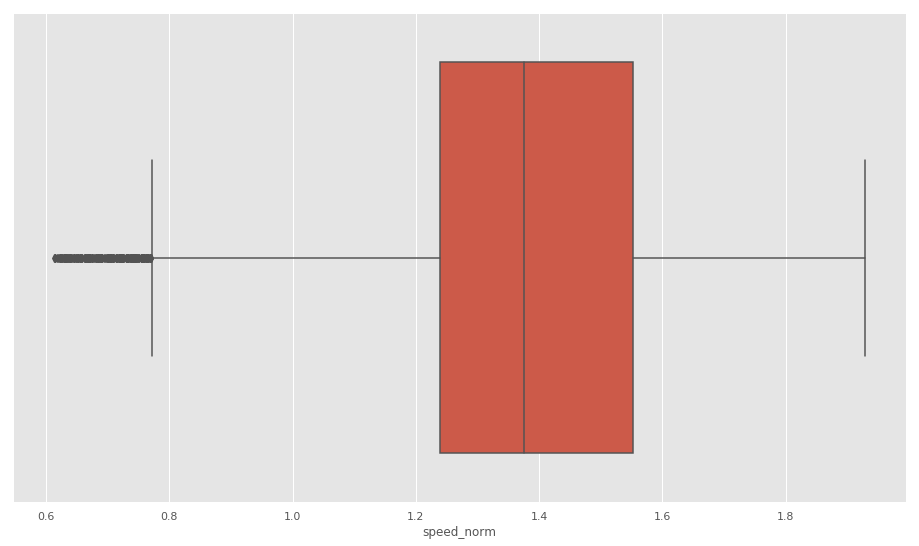

In [0]:
#BOXPLOT SPEED NORMALIZADA SIN OUTLIERS
sb.boxplot(x=bicimad_norm_out['speed_norm'])

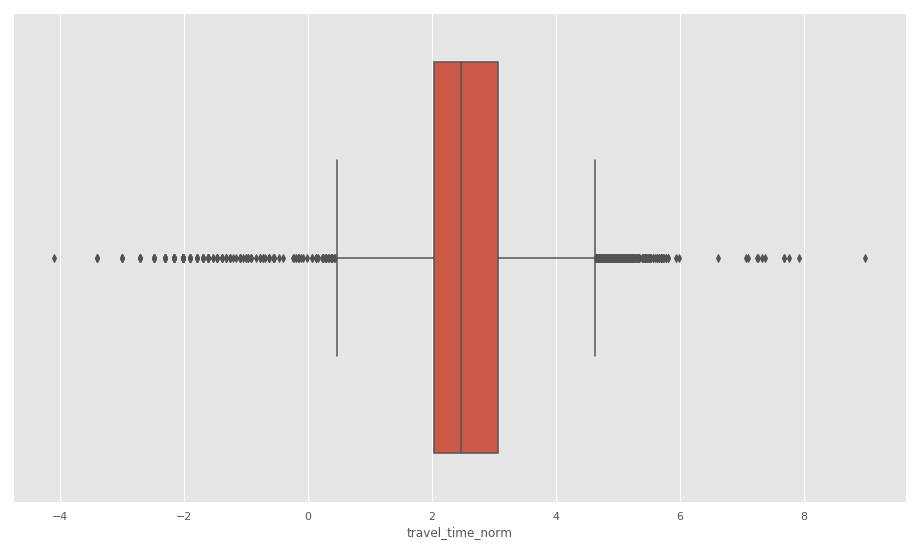

In [0]:
#BOXPLOT TRAVEL TIME NORMALIZADA SIN OUTLIERS

sb.boxplot(x=bicimad_norm['travel_time_norm'])

### d. Clusterización

#### K-means

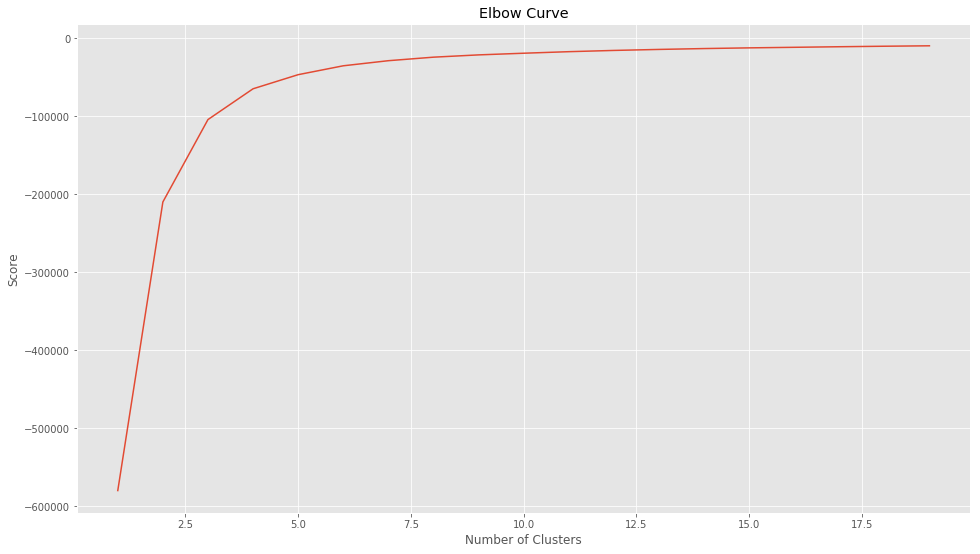

In [74]:
#K-MEANS SIN OUTLIERS 


X = np.array(bicimad_norm_out[["travel_time_min","speed",'user_type']])
y = np.array(bicimad_norm_out['ageRange'])
X.shape

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

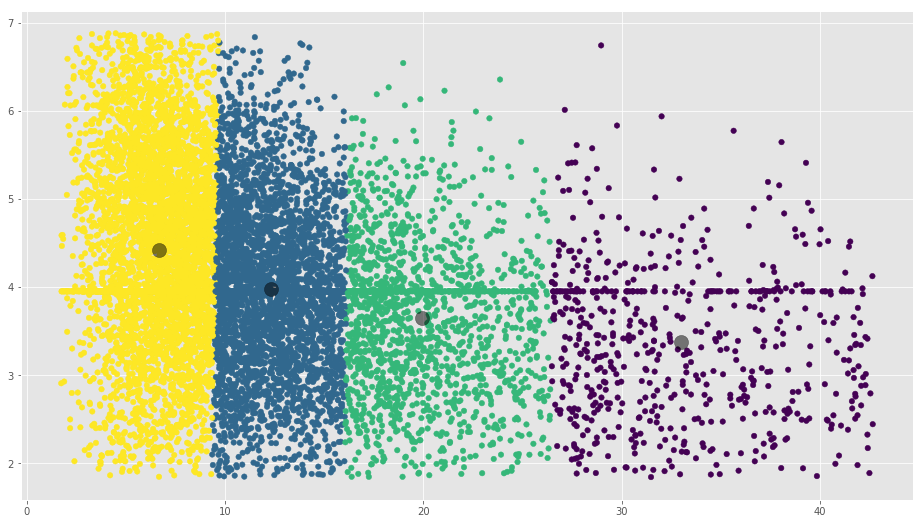

In [75]:
#Clusterizacion K-Means con 4 clusters 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

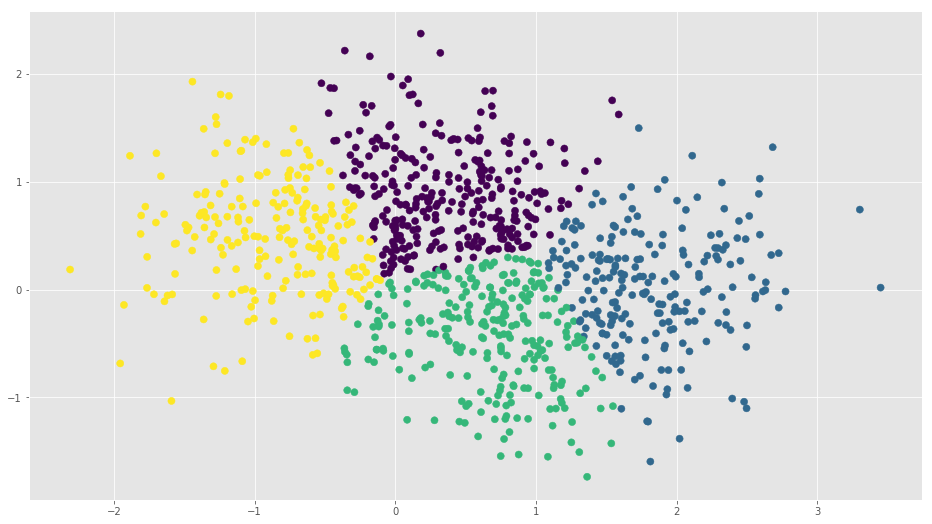

In [77]:
from sklearn.datasets import make_moons
X, y = make_moons(1000, noise=.5, random_state=10)
labels = KMeans(4, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

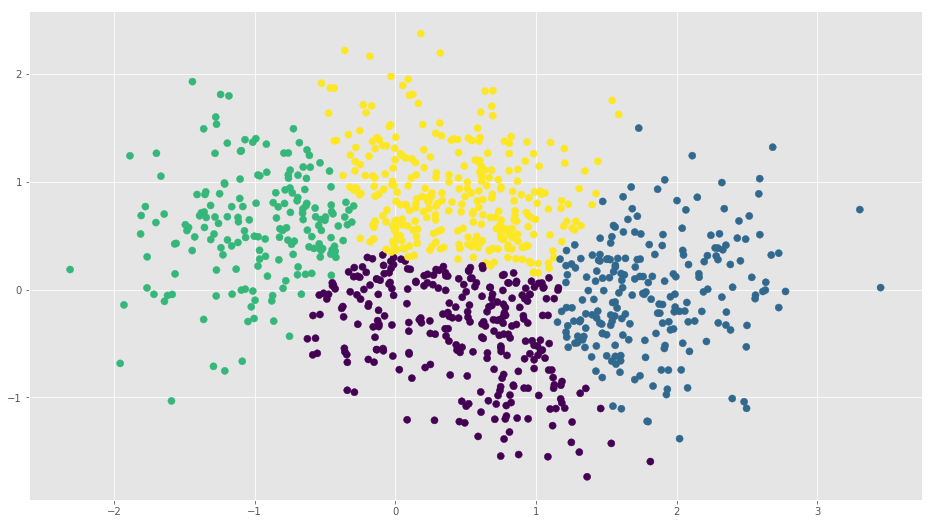

In [78]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=4, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Gaussiano ( Intentado no conseguido pero tampoco le vemos sentido)

In [82]:
bicimad_gauss = bicimad_norm_out.loc[:,['travel_time_min', 'speed', 'ageRange', 'user_type','weekday' ]]
bicimad_gauss1 = bicimad_norm.loc[:,['travel_time_min', 'speed', 'ageRange', 'user_type', 'weekday']]
bicimad_gauss.reset_index(drop=True)

bicimad_gauss1.describe()

,travel_time_min,speed,ageRange,user_type,weekday
count,14832.000000,14832.000000,14832.000000,14832.000000,14832.000000
mean,23.532875,4.001051,2.302117,1.277508,2.762945
std,86.221505,1.330971,2.169340,0.647697,1.921010
min,0.016667,0.000000,0.000000,1.000000,0.000000
25%,7.633333,3.229821,0.000000,1.000000,1.000000
50%,11.900000,3.954000,3.000000,1.000000,3.000000
75%,21.658333,4.693333,4.000000,1.000000,4.000000
max,8030.233333,30.720000,6.000000,3.000000,6.000000


In [0]:
def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

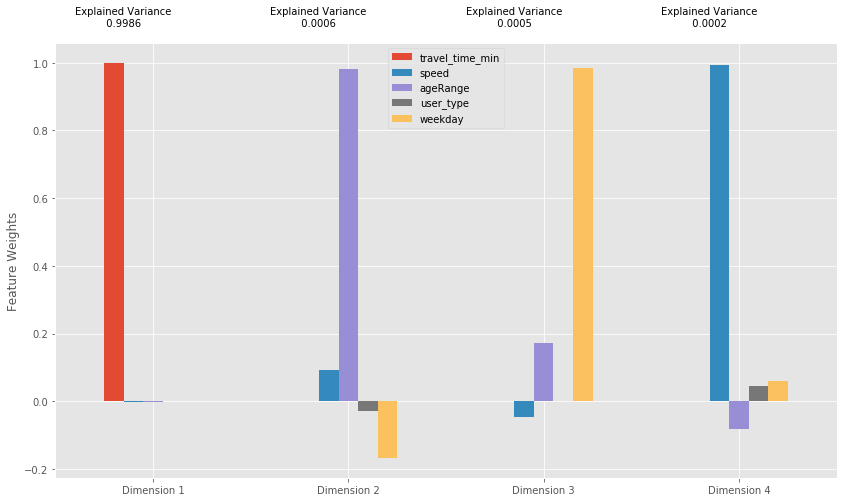

In [84]:
from sklearn.decomposition import PCA

# Entrena PCA con tantas dimensiones como columnas tienen los datos
pca = PCA(n_components=4).fit(bicimad_gauss1)



# GGenera el plot
pca_results = pca_results(bicimad_gauss1, pca)

In [85]:
# cluster para predecir cada cuanto hay que realizar mantenimiento a las bicis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for i in range(2,15):
    # Aplicar el algoritmo seleccionado sobre los datos reducidos con PCA
    clusterer = GaussianMixture(n_components=i, random_state = 45)
    clusterer.fit(bicimad_gauss)
    
    # Calcula la predicción para calcular el cluster de cada cliente
    preds = clusterer.predict(bicimad_gauss)

    # Identifica el centro de los clusters
    centers = clusterer.means_

    # Identifica el cluster para cada sample
  

    # Calcula el promedio del silhouette coefficient para los clusters seleccionados
    score = silhouette_score(bicimad_gauss,preds)
    print (i, score)

2 0.5558304918744084
3 0.38894770311400684
4 0.3100244334367217
5 0.10833754121569789
6 0.06599671667761857
7 0.19156004933627782
8 0.2437180977096765
9 0.19404038481581154
10 0.1648375601932844
11 0.19133591556593393
12 0.12021133840861645
13 0.159268807593158
14 0.10512870955729353


In [86]:
# cluster para predecir cada cuanto hay que realizar mantenimiento a las bicis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

for i in range(2,15):
    # Aplicar el algoritmo seleccionado sobre los datos reducidos con PCA
    clusterer = GaussianMixture(n_components=i, random_state = 45)
    clusterer.fit(bicimad_gauss1)
    
    # Calcula la predicción para calcular el cluster de cada cliente
    preds = clusterer.predict(bicimad_gauss1)

    # Identifica el centro de los clusters
    centers = clusterer.means_

    # Identifica el cluster para cada sample
  

    # Calcula el promedio del silhouette coefficient para los clusters seleccionados
    score = silhouette_score(bicimad_gauss1,preds)
    print (i, score)

2 0.5396455055697479
3 0.5157237796971677
4 0.5695712410279127
5 0.5580296635267827
6 0.2901645269409709
7 0.03650935667776308
8 0.40444759169161193
9 0.04194095615806987
10 0.05340472549543276
11 0.05650416715580403
12 0.05659337817793104
13 -0.16133806402435927
14 0.029085200465217967


In [88]:
datos_bicimad = bicimad_norm_out.loc[:,['unidad', 'user_type', 'ageRange', 'weekday']]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
import matplotlib.cm as cm
def cluster_results(bicimad_gauss, preds, centers, bicimad_norm):
	'''
	Visualizes the PCA-reduced cluster data in two dimensions
	Adds cues for cluster centers and student-selected sample data
	'''

	predictions = pd.DataFrame(preds, columns = ['Cluster'])
	plot_data = pd.concat([predictions, bicimad_norm], axis = 1)

	# Generate the cluster plot
	fig, ax = plt.subplots(figsize = (14,8))

	# Color map
	cmap = cm.get_cmap('gist_rainbow')

	# Color the points based on assigned cluster
	for i, cluster in plot_data.groupby('Cluster'):   
	    cluster.plot(ax = ax, kind = 'scatter', x = 'weekday', y = 'ageRange', \
	                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

	# Plot centers with indicators
	for i, c in enumerate(centers):
	    ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
	               alpha = 1, linewidth = 2, marker = 'o', s=200);
	    ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);



	# Set plot title
	ax.set_title("gaussiano");

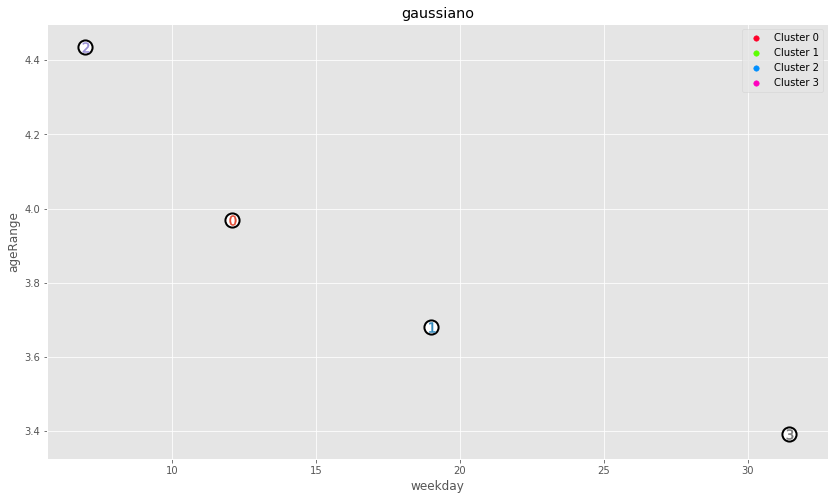

In [90]:
clusterer = GaussianMixture(n_components=4, random_state=45)
clusterer.fit(bicimad_gauss)

# Calcula la predicción para calcular el cluster de cada cliente
preds = clusterer.predict(bicimad_gauss)

# Identifica los centros de los clusters
centers = clusterer.means_

# Calcula la predicción para calcular el cluster de los samples de cliente
##sample_preds = clusterer.predict(bicimad_norm)

# Representa los resultados de la implementación
cluster_results(bicimad_norm, preds, centers, bicimad_gauss)

# CONCLUSIONES 
